# Masters Thesis


### Setting up working environment


In [3]:
!pip install -q otter-grader pandoc torch torchvision scikit-learn seaborn albumentations

In [15]:
# Initialization Cell
# @title Initilization Cell taken from previous coursework module COMP70010

try:
    WORKING_ENV = 'COLAB' # Can be LABS, COLAB, PAPERSPACE, SAGEMAKER
    USERNAME = 'your_username' # If working on Lab Machines - Your college username
    assert WORKING_ENV in ['LABS', 'COLAB', 'PAPERSPACE', 'SAGEMAKER']

    if WORKING_ENV == 'COLAB':
        from google.colab import drive
        %load_ext google.colab.data_table
        d1_cw1_repo_path = 'Lectureship/CW/dl_cw1/' # path in your gdrive to the repo
        content_path = f'/content/drive/MyDrive/DL_CW_1_ljc20/' # path to gitrepo in gdrive after mounting
        drive.mount('/content/drive/') # Outputs will be saved in your google drive

    elif WORKING_ENV == 'LABS':
        content_path = f'/vol/bitbucket/{USERNAME}/dl/dl_cw1/' # You may want to change this
        # Your python env and training data should be on bitbucket
        if 'vol' not in content_path:
            import warnings
            warnings.warn(
                'It is best to create a dir in /vol/bitbucket/ otherwise you will quickly run into memory issues'
            )

    elif WORKING_ENV == 'PAPERSPACE': # Using Paperspace
        # Paperspace does not properly render animated progress bars
        # Strongly recommend using the JupyterLab UI instead of theirs
        !pip install ipywidgets
        content_path = '/notebooks'

    elif WORKING_ENV == 'SAGEMAKER':
        content_path = '/home/studio-lab-user/sagemaker-studiolab-notebooks/'
    else:
        raise NotImplementedError()

    import otter
    import os
    if not os.path.exists(f'{content_path}tests'):
        raise ValueError('Cannot find the public tests folder')
    grader = otter.Notebook(
        f'{content_path}Drone_Detection.ipynb',
        tests_dir=f'{content_path}tests')
    import matplotlib.pyplot as plt # DO NOT use %matplotlib inline in the notebook
    import numpy as np
    rng_seed = 90
except:
    # This is a fallback initialization for running on LabTS. Please leave this in place before submission.
    import otter
    grader = otter.Notebook("Drone_Detection.ipynb")
    import matplotlib.pyplot as plt
    import numpy as np
    rng_seed = 90


The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Segmentation Networks


In [17]:
ON_COLAB = False


In [18]:
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
rng_seed = 90
torch.manual_seed(rng_seed)
import os
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import torch.optim as optim
from torchvision import models
from torch.utils.data.dataloader import default_collate
from torchvision.ops import nms
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [19]:

# @title Label Assignment Testing
# # ASSUMPTION MADE BASED ON DATASETS THAT IMAGES ARE JPG
# class CustomImageDatasetWithTextLabels(Dataset):
#     def __init__(self, img_dir, labels_dir, transform=None):
#         self.img_dir = img_dir
#         self.labels_dir = labels_dir
#         self.transform = transform
#         self.img_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith('.jpg')]

#     def __len__(self):
#         return len(self.img_names)

#     def __getitem__(self, idx):
#         img_name = self.img_names[idx]
#         img_path = os.path.join(self.img_dir, img_name)
#         image = Image.open(img_path).convert('RGB')

#         label_file = img_name.replace('.jpg', '.txt')
#         label_path = os.path.join(self.labels_dir, label_file)
#         with open(label_path, 'r') as f:
#             label = f.readline().strip()

#         if self.transform:
#             image = self.transform(image)

#         return image, label

# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(226),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])



# img_dir = ('/content/' if ON_COLAB else '') + 'drive/MyDrive/DL_CW_1_ljc20/train/images'
# labels_dir = ('/content/' if ON_COLAB else '') + 'drive/MyDrive/DL_CW_1_ljc20/train/labels'
# dataset = CustomImageDatasetWithTextLabels(img_dir=img_dir, labels_dir=labels_dir, transform=transform)

# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [20]:
# @title Datset Initialisation for unaugmented dataset
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

# Non augmented transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()),
])




class CustomImageDataset(Dataset):
    def __init__(self, img_dir, labels_dir, transform=None):
        self.img_dir = img_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.img_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith('.jpg')]  # assuming images are .jpg

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        label_file = img_name.replace('.jpg', '.txt')
        label_path = os.path.join(self.labels_dir, label_file)

        label = torch.zeros(4, dtype=torch.float32)

        try:
            with open(label_path, 'r') as f:
                label_str = f.readline().strip()
                label_parts = [float(part) for part in label_str.split()][:4]
                if len(label_parts) == 4:  # Ensure the label has 4 parts
                    label = torch.tensor(label_parts, dtype=torch.float32)
        except IOError:
            print(f"Warning: Label file {label_file} not accessible or malformed.")

        if self.transform:
            image = self.transform(image)

        return image, label


train_img_dir = ('/content/' if ON_COLAB else '') + 'drive/MyDrive/DL_CW_1_ljc20/train/images'
train_labels_dir = ('/content/' if ON_COLAB else '') + 'drive/MyDrive/DL_CW_1_ljc20/train/labels'
val_img_dir = ('/content/' if ON_COLAB else '') +'drive/MyDrive/DL_CW_1_ljc20/valid/images'
val_labels_dir = ('/content/' if ON_COLAB else '') +'drive/MyDrive/DL_CW_1_ljc20/valid/labels'
test_img_dir = ('/content/' if ON_COLAB else '') +'drive/MyDrive/DL_CW_1_ljc20/test/images'
test_labels_dir = ('/content/' if ON_COLAB else '') +'drive/MyDrive/DL_CW_1_ljc20/test/lsbels'

def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    images = torch.stack(images, dim=0)

    labels = torch.stack(labels, dim=0)

    return images, labels

train_dataset = CustomImageDataset(train_img_dir, train_labels_dir, transform=transform)
val_dataset = CustomImageDataset(val_img_dir, val_labels_dir, transform=transform)
test_dataset = CustomImageDataset(test_img_dir, test_labels_dir, transform=transform)

batch_size = 32
loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [21]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()),
])
# Augmentations
train_transform_1 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()),
])


class CustomImageDataset(Dataset):
    def __init__(self, img_dir, labels_dir, transform=None):
        self.img_dir = img_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.img_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith('.jpg')]  # assuming images are .jpg

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        label_file = img_name.replace('.jpg', '.txt')
        label_path = os.path.join(self.labels_dir, label_file)

        label = torch.zeros(4, dtype=torch.float32)  # Assuming 4 values for bounding box

        try:
            with open(label_path, 'r') as f:
                label_str = f.readline().strip()
                label_parts = [float(part) for part in label_str.split()][:4]
                if len(label_parts) == 4:  # Ensure the label has 4 parts
                    label = torch.tensor(label_parts, dtype=torch.float32)
        except IOError:
            print(f"Warning: Label file {label_file} not accessible or malformed.")

        if self.transform:
            image = self.transform(image)

        return image, label


train_img_dir = ('/content/' if ON_COLAB else '') + 'drive/MyDrive/DL_CW_1_ljc20/train/images'
train_labels_dir = ('/content/' if ON_COLAB else '') + 'drive/MyDrive/DL_CW_1_ljc20/train/labels'
val_img_dir = ('/content/' if ON_COLAB else '') +'drive/MyDrive/DL_CW_1_ljc20/valid/images'
val_labels_dir = ('/content/' if ON_COLAB else '') +'drive/MyDrive/DL_CW_1_ljc20/valid/labels'
test_img_dir = ('/content/' if ON_COLAB else '') +'drive/MyDrive/DL_CW_1_ljc20/test/images'
test_labels_dir = ('/content/' if ON_COLAB else '') +'drive/MyDrive/DL_CW_1_ljc20/test/lsbels'

def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    images = torch.stack(images, dim=0)

    labels = torch.stack(labels, dim=0)

    return images, labels

train_dataset_unaugmented = CustomImageDataset(train_img_dir, train_labels_dir, transform=transform)
train_dataset_augmented1 = CustomImageDataset(train_img_dir, train_labels_dir, transform=train_transform_1)
val_dataset = CustomImageDataset(val_img_dir, val_labels_dir, transform=transform)
test_dataset = CustomImageDataset(test_img_dir, test_labels_dir, transform=transform)
train_sets = [train_dataset_unaugmented, train_dataset_augmented1]
Combined_Train_Set = ConcatDataset(train_sets)
batch_size = 32
loader_train = DataLoader(Combined_Train_Set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [22]:
for i, (image, label) in enumerate(train_dataset):
    print(image.shape, label.shape)
    if i > 10:
        break

torch.Size([3, 256, 256]) torch.Size([4])
torch.Size([3, 256, 256]) torch.Size([4])
torch.Size([3, 256, 256]) torch.Size([4])
torch.Size([3, 256, 256]) torch.Size([4])
torch.Size([3, 256, 256]) torch.Size([4])
torch.Size([3, 256, 256]) torch.Size([4])
torch.Size([3, 256, 256]) torch.Size([4])
torch.Size([3, 256, 256]) torch.Size([4])
torch.Size([3, 256, 256]) torch.Size([4])
torch.Size([3, 256, 256]) torch.Size([4])
torch.Size([3, 256, 256]) torch.Size([4])
torch.Size([3, 256, 256]) torch.Size([4])


In [23]:

unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1))

**Visualising some example images**

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


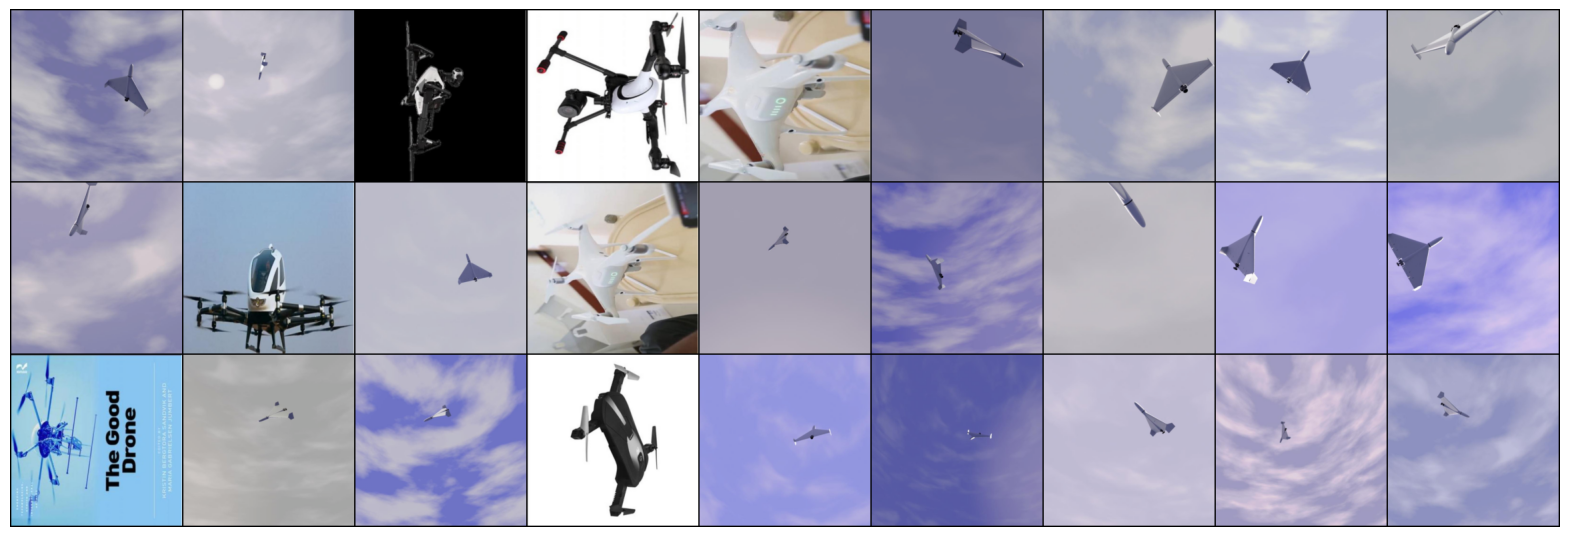

In [24]:
sample_inputs, _ = next(iter(loader_val))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

Next, we define ResNet-18:

In [25]:
# @title CustomCNN Model Implementation
# Setup parameter
IMG_HEIGHT = 256
IMG_WIDTH = 256
CHANNELS = 3



import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(CHANNELS, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)

        x = x.view(-1, self.num_flat_features(x))

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [26]:
# @title Improved Custom CNN

class ImprovedCustomCNN(nn.Module):
    def __init__(self):
        super(ImprovedCustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(CHANNELS, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x2 = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x3 = F.max_pool2d(F.relu(self.bn2(self.conv2(x2))), 2)
        x4 = F.max_pool2d(F.relu(self.bn3(self.conv3(x3))), 2)
        x5 = F.max_pool2d(F.relu(self.bn4(self.conv4(x4))), 2)
        x6 = F.max_pool2d(F.relu(self.bn5(self.conv5(x5))), 2)

        x = self.adaptive_pool(x6)
        x = torch.flatten(x6, 1)

        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


In [27]:
USE_GPU = True
dtype = torch.float32


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

cuda:0


In [28]:
# @title Training Loop for Segmentation Models

IMG_HEIGHT = 256
IMG_WIDTH = 256
CHANNELS = 3

model = ImprovedCustomCNN()
X_train = train_img_dir
y_train = train_labels_dir


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

num_epochs = 10
running_losses = []
val_losses = []
train_epoch_losses = []
val_epoch_losses = []
empoch_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print(f"Epoch {epoch}")
    counter = 0
    # Training
    for inputs, labels in loader_train:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_losses.append(running_loss)
        # print(counter)
        counter += 1
        if counter % 10 == 0:
          print(f"Epoch {epoch+1}/{num_epochs}, Iter: {counter}, Average Loss: {running_loss / (counter * inputs.size(0))}")

    epoch_loss = running_loss / len(loader_train.dataset)
    train_epoch_losses.append(epoch_loss)
    print(f"Training Loss: {epoch_loss:.4f}")


    # Validation
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader_val:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            val_losses.append(val_running_loss)

    val_epoch_loss = val_running_loss / len(loader_val.dataset)
    val_epoch_losses.append(val_epoch_loss)

    print(f"Validation Loss: {val_epoch_loss:.4f}")


Epoch 0


KeyboardInterrupt: 

#Single Object detection YOLOv3#

In [29]:
class YOLOv3Lite(nn.Module):
    def _make_detection_layer(self, in_channels, out_channels, output_filters):
      return nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 1),
          nn.BatchNorm2d(out_channels),
          nn.LeakyReLU(0.1),
          nn.Conv2d(out_channels, output_filters, 3, padding=1)
      )
    def __init__(self, anchors):
        super(YOLOv3Lite, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors) // 3  # We use three output scales

        # Backbone
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=2)
        self.bn5 = nn.BatchNorm2d(512)

        self.det1 = self._make_detection_layer(512, 256, 256)
        self.det2 = self._make_detection_layer(256, 128, 128)
        self.det3 = self._make_detection_layer(128, 64, 64)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.1)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.1)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.1)

        out1 = self.det1(x)
        out2 = self.det2(out1)
        out3 = self.det3(out2)

        return out1, out2, out3



# Testing to check dimensions
dummy_input = torch.randn(1, 3, 256, 256)

anchors = [(10, 13), (16, 30), (33, 23), (30, 61), (62, 45), (59, 119), (116, 90), (156, 198), (373, 326)]
model = YOLOv3Lite(anchors)

output = model(dummy_input)
for out in output:
    print("Output shape:", out.shape)

print(output[-1])

Output shape: torch.Size([1, 256, 16, 16])
Output shape: torch.Size([1, 128, 16, 16])
Output shape: torch.Size([1, 64, 16, 16])
tensor([[[[ 2.4290e-01,  5.0974e-01,  2.0446e-01,  ..., -1.9309e-01,
            7.5419e-02,  1.1120e-01],
          [ 1.8611e-01, -8.9178e-02,  1.3719e-01,  ..., -4.1487e-02,
           -6.5010e-01, -1.0490e-01],
          [-2.3966e-01, -8.4409e-01,  6.8406e-01,  ...,  5.1125e-01,
           -8.9387e-02, -3.1579e-01],
          ...,
          [-2.5594e-01, -5.7287e-01, -1.2894e-01,  ..., -3.9660e-01,
           -5.5816e-01, -2.8163e-01],
          [ 3.0398e-02, -1.9957e-01, -4.9140e-01,  ...,  3.1849e-01,
           -7.4924e-02, -4.0929e-01],
          [-2.4992e-01,  3.6716e-01, -5.7164e-01,  ...,  2.5738e-02,
            9.6378e-02, -3.1241e-01]],

         [[-2.0641e-01,  4.1775e-01,  9.4494e-02,  ...,  5.6624e-02,
           -4.0578e-02,  1.2284e-01],
          [-3.4023e-01,  1.9993e-01, -1.6912e-01,  ..., -3.1223e-01,
            6.1057e-02,  1.4410e-01],

In [30]:
# Similar code as previous additional layer added
class YOLOv3LiteDeep(nn.Module):
    def _make_detection_layer(self, in_channels, out_channels, output_filters):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(out_channels, output_filters, 3, padding=1)
        )

    def __init__(self, anchors):
        super(YOLOv3LiteDeep, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors) // 3

        # Backbone
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=2)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=1, stride=2)
        self.bn6 = nn.BatchNorm2d(1024)

        # Detection
        self.det1 = self._make_detection_layer(1024, 512, 512)
        self.det2 = self._make_detection_layer(512, 256, 256)
        self.det3 = self._make_detection_layer(256, 128, 128)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.1)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.1)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.1)
        x = F.leaky_relu(self.bn6(self.conv6(x)), 0.1)

        out1 = self.det1(x)
        out2 = self.det2(out1)
        out3 = self.det3(out2)

        return out1, out2, out3

# Model tests with dummy input
dummy_input = torch.randn(1, 3, 256, 256)

anchors = [(10, 13), (16, 30), (33, 23), (30, 61), (62, 45), (59, 119), (116, 90), (156, 198), (373, 326)]
model = YOLOv3LiteDeep(anchors)

output = model(dummy_input)
for out in output:
    print("Output shape:", out.shape)
print(output[-1])

Output shape: torch.Size([1, 512, 8, 8])
Output shape: torch.Size([1, 256, 8, 8])
Output shape: torch.Size([1, 128, 8, 8])
tensor([[[[-0.2900, -0.0844, -0.2512,  ..., -0.1818, -0.4192, -0.1905],
          [-0.3120,  0.3237, -0.0484,  ...,  0.3966,  0.4194,  0.0211],
          [ 0.2203, -0.1522, -0.0410,  ...,  0.0863, -0.1052, -0.0088],
          ...,
          [ 0.0918, -0.5783, -0.3523,  ..., -0.2675,  0.4287, -0.2342],
          [ 0.0294, -0.1496, -0.2316,  ..., -0.4378,  0.9356,  0.7197],
          [ 0.2558, -0.3741,  0.0294,  ..., -0.4034, -0.1535, -0.1184]],

         [[-0.1267, -0.2620, -0.4146,  ..., -0.0661, -0.4475,  0.0385],
          [-0.5208, -0.4053, -0.4400,  ..., -0.5584, -0.2395, -0.3301],
          [-0.6163, -0.2680,  0.0603,  ..., -0.2502, -0.3194,  0.0453],
          ...,
          [-0.0108, -0.1137, -0.6928,  ...,  0.0513, -0.6333,  0.2342],
          [-0.4584, -1.0842, -1.0177,  ..., -0.6234, -0.3371, -0.0880],
          [-0.4290, -0.0572, -1.1090,  ..., -0.0638, 

In [31]:
# Transformed backbone to contain residual blocks

# Residual building block used in model
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(channels // 2)
        self.conv2 = nn.Conv2d(channels // 2, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1)
        x += residual
        return x

# Actual Model built using residual blocks
class YOLOv3LiteRes(nn.Module):
    def _make_detection_layer(self, in_channels, out_channels, output_filters):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(out_channels, output_filters, 3, padding=1)
        )

    def __init__(self, anchors):
        super(YOLOv3LiteRes, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors) // 3  # Three output scales as usual

        # Backbone wity residual blocks inclued
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.residual1 = ResidualBlock(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.residual2 = ResidualBlock(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2)
        self.bn4 = nn.BatchNorm2d(256)
        self.residual3 = ResidualBlock(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=2)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=1, stride=2)
        self.bn6 = nn.BatchNorm2d(1024)

        self.det1 = self._make_detection_layer(1024, 512, 256)
        self.det2 = self._make_detection_layer(256, 256, 128)
        self.det3 = self._make_detection_layer(128, 128, 64)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1)
        x = self.residual1(x)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.1)
        x = self.residual2(x)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.1)
        x = self.residual3(x)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.1)
        x = F.leaky_relu(self.bn6(self.conv6(x)), 0.1)

        out1 = self.det1(x)
        out2 = self.det2(out1)
        out3 = self.det3(out2)

        return out1, out2, out3


dummy_input = torch.randn(1, 3, 256, 256)


anchors = [(10, 13), (16, 30), (33, 23), (30, 61), (62, 45), (59, 119), (116, 90), (156, 198), (373, 326)]
model = YOLOv3LiteRes(anchors)


output = model(dummy_input)
for out in output:
    print("Output shape:", out.shape)


Output shape: torch.Size([1, 256, 8, 8])
Output shape: torch.Size([1, 128, 8, 8])
Output shape: torch.Size([1, 64, 8, 8])


In [32]:
# New model using an improved residual block
# New residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels=None, stride=1):
        super(ResidualBlock, self).__init__()
        if out_channels is None:
            out_channels = in_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.skip(x)
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        x = self.bn2(self.conv2(x))
        x = F.leaky_relu(x + residual, 0.1)
        return x

# New model with improved residual block
class YOLOv3LiteResDeeper(nn.Module):
    def _make_detection_layer(self, in_channels, out_channels, output_filters):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(out_channels, output_filters, 3, padding=1)
        )

    def __init__(self, anchors):
        super(YOLOv3LiteResDeeper, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors) // 3
        # New backbone
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            ResidualBlock(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
        )
        self.layer5 = nn.Sequential(
            ResidualBlock(512),
            ResidualBlock(512),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
        )

        self.det1 = self._make_detection_layer(1024, 512, 512)
        self.det2 = self._make_detection_layer(512, 256, 256)
        self.det3 = self._make_detection_layer(256, 128, 64)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        out1 = self.det1(x)
        out2 = self.det2(out1)
        out3 = self.det3(out2)
        return out1, out2, out3


dummy_input = torch.randn(1, 3, 256, 256)

anchors = [(10, 13), (16, 30), (33, 23), (30, 61), (62, 45), (59, 119), (116, 90), (156, 198), (373, 326)]
model = YOLOv3LiteResDeeper(anchors)

output = model(dummy_input)
for out in output:
    print("Output shape:", out.shape)


Output shape: torch.Size([1, 512, 8, 8])
Output shape: torch.Size([1, 256, 8, 8])
Output shape: torch.Size([1, 64, 8, 8])


#Multi object detection#

In [33]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(channels // 2)
        self.conv2 = nn.Conv2d(channels // 2, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1)
        x += residual
        return x

class YOLOv3LiteResMulClass(nn.Module):
    def __init__(self, anchors):
        super(YOLOv3LiteResMulClass, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors) // 3

        # Backbone
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.residual1 = ResidualBlock(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.residual2 = ResidualBlock(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2)
        self.bn4 = nn.BatchNorm2d(256)
        self.residual3 = ResidualBlock(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=2)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=1, stride=2)
        self.bn6 = nn.BatchNorm2d(1024)

        # Detection
        self.det1 = self._make_detection_layer(1024, 512, 256)
        self.det2 = self._make_detection_layer(256, 256, 128)
        self.det3 = self._make_detection_layer(128, 128, 64)

    def _make_detection_layer(self, in_channels, out_channels, output_filters):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(out_channels, output_filters, 3, padding=1)
        )

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1)
        x = self.residual1(x)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.1)
        x = self.residual2(x)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.1)
        x = self.residual3(x)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.1)
        x = F.leaky_relu(self.bn6(self.conv6(x)), 0.1)

        out1 = self.det1(x)
        out2 = self.det2(out1)
        out3 = self.det3(out2)

        return out1, out2, out3

dummy_input = torch.randn(1, 3, 256, 256)

anchors = [(10, 13), (16, 30), (33, 23), (30, 61), (62, 45), (59, 119), (116, 90), (156, 198), (373, 326)]
model = YOLOv3LiteResMulClass(anchors)

output = model(dummy_input)
for out in output:
    print("Output shape:", out.shape)

Output shape: torch.Size([1, 256, 8, 8])
Output shape: torch.Size([1, 128, 8, 8])
Output shape: torch.Size([1, 64, 8, 8])


In [34]:
# YOLOv3 model using transfer learned backbone

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(channels // 2)
        self.conv2 = nn.Conv2d(channels // 2, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1)
        x += residual
        return x

class YOLOv3LiteResMulClassTransfer(nn.Module):
    def __init__(self, anchors, backbone_pretrained=True):
        super(YOLOv3LiteResMulClassTransfer, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors) // 3

        # New transfer learned backbone based on resnet 50
        self.backbone = models.resnet50(pretrained=backbone_pretrained)
        # Fully connected layers removed to make it applicale
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])


        self.conv1 = nn.Conv2d(2048, 1024, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.det1 = self._make_detection_layer(1024, 512, 256)
        self.det2 = self._make_detection_layer(256, 256, 128)
        self.det3 = self._make_detection_layer(128, 128, 64)

    def _make_detection_layer(self, in_channels, out_channels, output_filters):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(out_channels, output_filters, 3, padding=1)
        )

    def forward(self, x):
        x = self.backbone(x)

        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)

        out1 = self.det1(x)
        out2 = self.det2(out1)
        out3 = self.det3(out2)

        return out1, out2, out3

dummy_input = torch.randn(1, 3, 256, 256)

anchors = [(10, 13), (16, 30), (33, 23), (30, 61), (62, 45), (59, 119), (116, 90), (156, 198), (373, 326)]
model = YOLOv3LiteResMulClassTransfer(anchors)

output = model(dummy_input)
for out in output:
    print("Output shape:", out.shape)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 216MB/s]


Output shape: torch.Size([1, 256, 8, 8])
Output shape: torch.Size([1, 128, 8, 8])
Output shape: torch.Size([1, 64, 8, 8])


In [35]:
# YOLOv3 usind a darknet backbone
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leaky_relu(self.bn(self.conv(x)))

class DarknetBlock(nn.Module):
    def __init__(self, in_channels):
        super(DarknetBlock, self).__init__()
        mid_channels = in_channels // 2
        self.conv1 = ConvBlock(in_channels, mid_channels, 1, 1, 0)
        self.conv2 = ConvBlock(mid_channels, in_channels, 3, 1, 1)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)
        x += residual
        return x

class Darknet53(nn.Module):
    def __init__(self):
        super(Darknet53, self).__init__()
        self.conv1 = ConvBlock(3, 32, 3, 1, 1)
        self.conv2 = ConvBlock(32, 64, 3, 2, 1)
        self.dark1 = self._make_n_darknet_blocks(64, 1)
        self.conv3 = ConvBlock(64, 128, 3, 2, 1)
        self.dark2 = self._make_n_darknet_blocks(128, 2)
        self.conv4 = ConvBlock(128, 256, 3, 2, 1)
        self.dark3 = self._make_n_darknet_blocks(256, 8)
        self.conv5 = ConvBlock(256, 512, 3, 2, 1)
        self.dark4 = self._make_n_darknet_blocks(512, 8)
        self.conv6 = ConvBlock(512, 1024, 3, 2, 1)
        self.dark5 = self._make_n_darknet_blocks(1024, 4)

    def _make_n_darknet_blocks(self, channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(DarknetBlock(channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dark1(x)
        x = self.conv3(x)
        x = self.dark2(x)
        x = self.conv4(x)
        x = self.dark3(x)
        x = self.conv5(x)
        x = self.dark4(x)
        x = self.conv6(x)
        x = self.dark5(x)
        return x

class YOLOv3LiteResMulClassDarknet(nn.Module):
    def __init__(self, anchors):
        super(YOLOv3LiteResMulClassDarknet, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors) // 3  # Three scales

        #  Darknet53backbone
        self.backbone = Darknet53()

        self.conv1 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.det1 = self._make_detection_layer(1024, 512, 256)
        self.det2 = self._make_detection_layer(256, 256, 128)
        self.det3 = self._make_detection_layer(128, 128, 64)

    def _make_detection_layer(self, in_channels, out_channels, output_filters):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(out_channels, output_filters, 3, padding=1)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        out1 = self.det1(x)
        out2 = self.det2(out1)
        out3 = self.det3(out2)
        return out1, out2, out3

dummy_input = torch.randn(1, 3, 256, 256)  # Added the batch dimension

anchors = [(10, 13), (16, 30), (33, 23), (30, 61), (62, 45), (59, 119), (116, 90), (156, 198), (373, 326)]
model = YOLOv3LiteResMulClassDarknet(anchors)

output = model(dummy_input)
for out in output:
    print("Output shape:", out.shape)


Output shape: torch.Size([1, 256, 8, 8])
Output shape: torch.Size([1, 128, 8, 8])
Output shape: torch.Size([1, 64, 8, 8])


In [36]:
# My attempt at a preliminary YOLOv5 model

class Conv(nn.Module):
    def __init__(self, c1, c2, k=1, s=1, p=0):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, stride=s, padding=p, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.silu = nn.SiLU()

    def forward(self, x):
        return self.silu(self.bn(self.conv(x)))

class CSPBlock(nn.Module):
    def __init__(self, channels, n=1):
        super().__init__()
        half_channels = channels // 2
        self.conv1 = Conv(channels, half_channels)
        self.convs = nn.Sequential(*[Conv(half_channels, half_channels) for _ in range(n)])

        self.conv3 = Conv(channels, half_channels)  # Adjusted to take concatenated output

        self.conv4 = Conv(half_channels, channels)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.convs(x1)
        x3 = torch.cat((x1, x2), dim=1)
        x4 = self.conv3(x3)
        return self.conv4(x4)

class SPP(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.maxpool = nn.ModuleList([
            nn.MaxPool2d(kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=9, stride=1, padding=4),
            nn.MaxPool2d(kernel_size=13, stride=1, padding=6)
        ])
        self.conv = Conv(channels * 4, channels)

    def forward(self, x):
        x = torch.cat([x] + [m(x) for m in self.maxpool], 1)
        return self.conv(x)

class YOLOv5Lite(nn.Module):
    def __init__(self, num_classes, anchors):
        super().__init__()
        self.num_classes = num_classes
        self.anchors = anchors
        self.initial_conv = Conv(3, 32, 3, 1, 1)
        self.csp_block1 = CSPBlock(32, n=1)
        self.transition1 = Conv(32, 64, 3, 2, 1)

        self.csp_block2 = CSPBlock(64, n=2)
        self.transition2 = Conv(64, 128, 3, 2, 1)
        self.spp = SPP(128)
        self.csp_block3 = CSPBlock(128, n=3)

        # Heads for different scales
        self.small_scale_head = Conv(128, len(anchors) // 3 * (num_classes + 5), 1, 1)
        self.medium_scale_head = Conv(64, len(anchors) // 3 * (num_classes + 5), 1, 1)
        self.large_scale_head = Conv(32, len(anchors) // 3 * (num_classes + 5), 1, 1)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.csp_block1(x)
        large = self.large_scale_head(x)

        x = self.transition1(x)
        x = self.csp_block2(x)
        medium = self.medium_scale_head(x)

        x = self.transition2(x)
        x = self.spp(x)
        x = self.csp_block3(x)
        small = self.small_scale_head(x)

        return large, medium, small

# Model test
model = YOLOv5Lite(num_classes=2, anchors=[(10, 13), (16, 30), (33, 23), (30, 61), (62, 45), (59, 119), (116, 90), (156, 198), (373, 326)])
dummy_input = torch.randn(1, 3, 256, 256)
output = model(dummy_input)
for o in output:
    print("Output shape:", o.shape)


Output shape: torch.Size([1, 21, 256, 256])
Output shape: torch.Size([1, 21, 128, 128])
Output shape: torch.Size([1, 21, 64, 64])


In [37]:
! pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=155353da7485774210cd587c42a66c2cedfe6e5efef8b92c3cb6c48d63aa7917
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [38]:
# NEW VERSION WITH NEGATIVES WHICH ARE PLANES SINGLE OBJECT DATASET WITH NEW NEGATIVES

mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()),
])
train_transform_1 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()),
])

train_transform_2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()),
])
# Create positive dataset
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, labels_dir, transform=None):
        self.img_dir = img_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.img_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith('.jpg')]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        label_file = img_name.replace('.jpg', '.txt')
        label_path = os.path.join(self.labels_dir, label_file)
        label = torch.zeros(5, dtype=torch.float32)  # Initialize label tensor with zeros

        try:
            with open(label_path, 'r') as f:
                line = f.readline().strip()
                parts = list(map(float, line.split()))
                if len(parts) == 5:
                    label = torch.tensor(parts, dtype=torch.float32)
                else:
                    raise ValueError(f"Label file {label_file} does not contain exactly 5 elements.")
        except (IOError, ValueError) as e:
            print(f"Warning: {e} Handling {label_file}.")

        label[0] = 1

        if self.transform:
            image = self.transform(image)
        label[0] = 1
        return image, label
# Create negative dataset
class CustomImageDatasetNeg(Dataset):
    def __init__(self, img_dir, labels_dir, transform=None):
        self.img_dir = img_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.img_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith('.jpg')]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        label_file = img_name.replace('.jpg', '.txt')
        label_path = os.path.join(self.labels_dir, label_file)
        label = torch.zeros(5, dtype=torch.float32)

        try:
            with open(label_path, 'r') as f:
                line = f.readline().strip()
                parts = list(map(float, line.split()))
                if len(parts) == 5:
                    label = torch.tensor(parts, dtype=torch.float32)
                else:
                    raise ValueError(f"Label file {label_file} does not contain exactly 5 elements.")
        except (IOError, ValueError) as e:
            print(f"Warning: {e} Handling {label_file}.")

        # Set the first element of the label tensor to 1
        label[0] = 0

        if self.transform:
            image = self.transform(image)
        label[0] = 0
        return image, label

train_img_dir = ('/content/' if ON_COLAB else '') + 'drive/MyDrive/DL_CW_1_ljc20/train/images'
train_labels_dir = ('/content/' if ON_COLAB else '') + 'drive/MyDrive/DL_CW_1_ljc20/train/labels'
val_img_dir = ('/content/' if ON_COLAB else '') +'drive/MyDrive/DL_CW_1_ljc20/valid/images'
val_labels_dir = ('/content/' if ON_COLAB else '') +'drive/MyDrive/DL_CW_1_ljc20/valid/labels'
test_img_dir = ('/content/' if ON_COLAB else '') +'drive/MyDrive/DL_CW_1_ljc20/test/images'
test_labels_dir = ('/content/' if ON_COLAB else '') +'drive/MyDrive/DL_CW_1_ljc20/test/lsbels'

def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    images = torch.stack(images, dim=0)
    labels = torch.stack(labels, dim=0)

    return images, labels


negatives_train_label = ('/content/' if ON_COLAB else '') + '/content/drive/MyDrive/DL_CW_1_ljc20/skymonioring'
negatives_train_image = ('/content/' if ON_COLAB else '') +'/content/drive/MyDrive/DL_CW_1_ljc20/skymonioring'

train_dataset_neg = CustomImageDatasetNeg(negatives_train_image, negatives_train_label, transform=transform)
train_dataset_neg_augmented1 = CustomImageDatasetNeg(negatives_train_image, negatives_train_label, transform=train_transform_1)
n = len(train_dataset_neg)
n_val = int(n / 10)

train_set_neg, val_set_neg = torch.utils.data.random_split(train_dataset_neg, [n - n_val, n_val])
train_dataset_unaugmented = CustomImageDataset(train_img_dir, train_labels_dir, transform=transform)
train_dataset_augmented1 = CustomImageDataset(train_img_dir, train_labels_dir, transform=train_transform_1)
train_dataset_augmented2 = CustomImageDataset(train_img_dir, train_labels_dir, transform=train_transform_2)

val_dataset = CustomImageDataset(val_img_dir, val_labels_dir, transform=transform)
test_dataset = CustomImageDataset(test_img_dir, test_labels_dir, transform=transform)
train_sets = [train_dataset_unaugmented, train_set_neg, train_dataset_neg_augmented1]
Combined_Train_Set = ConcatDataset(train_sets)
val_sets = [val_set_neg, val_dataset]
Combined_Val_Set = ConcatDataset(val_sets)
batch_size = 32
loader_train = DataLoader(Combined_Train_Set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(Combined_Val_Set, batch_size=batch_size, shuffle=False, num_workers=2)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print(len(Combined_Train_Set), len(val_dataset), len(test_dataset))


10887 1276 637


In [39]:
# NEW VERSION WITH NEGATIVES WHICH ARE PLANES HANDLING LABELS BETTER
# MULTIPLE DRONES PER IMAGE

mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()),
])
# Augmented
train_transform_1 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()),
])

train_transform_2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()),
])

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, labels_dir, transform=None):
        self.img_dir = img_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.img_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith('.jpg')]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        label_file = img_name.replace('.jpg', '.txt')
        label_path = os.path.join(self.labels_dir, label_file)
        labels = []

        try:
            with open(label_path, 'r') as f:
                for line in f:
                    parts = list(map(float, line.strip().split()))
                    if len(parts) == 5:
                        parts[0]=1
                        labels.append(parts)
                    else:
                        raise ValueError(f"Label file {label_file} does not contain exactly 5 elements.")
        except (IOError, ValueError) as e:
            print(f"Warning: {e} Handling {label_file}.")

        labels = torch.tensor(labels, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, labels

class CustomImageDatasetNeg(Dataset):
    def __init__(self, img_dir, labels_dir, transform=None):
        self.img_dir = img_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.img_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith('.jpg')]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        label_file = img_name.replace('.jpg', '.txt')
        label_path = os.path.join(self.labels_dir, label_file)
        labels = []

        try:
            with open(label_path, 'r') as f:
                for line in f:
                    parts = list(map(float, line.strip().split()))
                    if len(parts) == 5:
                        parts[0]=0
                        labels.append(parts)
                    else:
                        raise ValueError(f"Label file {label_file} does not contain exactly 5 elements.")
        except (IOError, ValueError) as e:
            print(f"Warning: {e} Handling {label_file}.")

        labels = torch.tensor(labels, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, labels

train_img_dir = ('/content/' if ON_COLAB else '') + 'drive/MyDrive/DL_CW_1_ljc20/train/images'
train_labels_dir = ('/content/' if ON_COLAB else '') + 'drive/MyDrive/DL_CW_1_ljc20/train/labels'
val_img_dir = ('/content/' if ON_COLAB else '') +'drive/MyDrive/DL_CW_1_ljc20/valid/images'
val_labels_dir = ('/content/' if ON_COLAB else '') +'drive/MyDrive/DL_CW_1_ljc20/valid/labels'
test_img_dir = ('/content/' if ON_COLAB else '') +'drive/MyDrive/DL_CW_1_ljc20/test/images'
test_labels_dir = ('/content/' if ON_COLAB else '') +'drive/MyDrive/DL_CW_1_ljc20/test/lsbels'

def collate_fn(batch):
    batch = list(filter(None, batch))

    if not batch:
        return torch.Tensor(), []

    images = torch.stack([item[0] for item in batch], dim=0)  # Images are stacked
    labels = [item[1] for item in batch]  # labels are grouped per image

    return images, labels



negatives_train_label = ('/content/' if ON_COLAB else '') + '/content/drive/MyDrive/DL_CW_1_ljc20/skymonioring'
negatives_train_image = ('/content/' if ON_COLAB else '') +'/content/drive/MyDrive/DL_CW_1_ljc20/skymonioring'

train_dataset_neg = CustomImageDatasetNeg(negatives_train_image, negatives_train_label, transform=transform)
train_dataset_neg_augmented1 = CustomImageDatasetNeg(negatives_train_image, negatives_train_label, transform=train_transform_1)
n = len(train_dataset_neg)
n_val = int(n / 10)

train_set_neg, val_set_neg = torch.utils.data.random_split(train_dataset_neg, [n - n_val, n_val])
train_dataset_unaugmented = CustomImageDataset(train_img_dir, train_labels_dir, transform=transform)
train_dataset_augmented1 = CustomImageDataset(train_img_dir, train_labels_dir, transform=train_transform_1)
train_dataset_augmented2 = CustomImageDataset(train_img_dir, train_labels_dir, transform=train_transform_2)

val_dataset = CustomImageDataset(val_img_dir, val_labels_dir, transform=transform)
test_dataset = CustomImageDataset(test_img_dir, test_labels_dir, transform=transform)
train_sets = [train_dataset_unaugmented, train_set_neg, train_dataset_neg_augmented1]
Combined_Train_Set = ConcatDataset(train_sets)
val_sets = [val_set_neg, val_dataset]
Combined_Val_Set = ConcatDataset(val_sets)
batch_size = 32
loader_train = DataLoader(Combined_Train_Set, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
loader_val = DataLoader(Combined_Val_Set, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)
print(len(Combined_Train_Set), len(val_dataset), len(test_dataset))


10887 1276 637


#Decode Predictions for Single Objects#

In [40]:
# Maximum score decode prediction
def decode_predictions(predictions, anchors, image_size, grid_size):
    batch_size = predictions[0].size(0)
    num_anchors_per_scale = len(anchors) // 3
    combined_obj = torch.zeros(batch_size, num_anchors_per_scale * 3, grid_size, grid_size, device=predictions[0].device)
    combined_bbox = torch.zeros(batch_size, num_anchors_per_scale * 3, grid_size, grid_size, 4, device=predictions[0].device)

    anchor_splits = [anchors[:num_anchors_per_scale], anchors[num_anchors_per_scale:2*num_anchors_per_scale], anchors[2*num_anchors_per_scale:]]

    for scale_idx, scale_pred in enumerate(predictions):
        scale_anchors = anchor_splits[scale_idx]
        for anchor_idx in range(num_anchors_per_scale):
            anchor_offset = scale_idx * num_anchors_per_scale + anchor_idx
            objectness = torch.sigmoid(scale_pred[:, anchor_idx * 5 + 4, :, :])
            bbox_x = (torch.sigmoid(scale_pred[:, anchor_idx * 5, :, :]) + torch.arange(grid_size, device=scale_pred.device).view(-1, 1).expand(-1, grid_size)) / grid_size
            bbox_y = (torch.sigmoid(scale_pred[:, anchor_idx * 5 + 1, :, :]) + torch.arange(grid_size, device=scale_pred.device).view(1, -1).expand(grid_size, -1)) / grid_size
            bbox_w = torch.exp(scale_pred[:, anchor_idx * 5 + 2, :, :]) * scale_anchors[anchor_idx][0] / image_size
            bbox_h = torch.exp(scale_pred[:, anchor_idx * 5 + 3, :, :]) * scale_anchors[anchor_idx][1] / image_size

            combined_obj[:, anchor_offset, :, :] = objectness
            combined_bbox[:, anchor_offset, :, :, 0] = bbox_x
            combined_bbox[:, anchor_offset, :, :, 1] = bbox_y
            combined_bbox[:, anchor_offset, :, :, 2] = bbox_w
            combined_bbox[:, anchor_offset, :, :, 3] = bbox_h

    flat_obj = combined_obj.view(batch_size, -1)
    flat_bbox = combined_bbox.view(batch_size, -1, 4)
    max_obj, max_indices = flat_obj.max(1)
    max_bbox = flat_bbox[torch.arange(batch_size), max_indices]

    return max_obj, max_bbox

dummy_input = torch.randn(32, 3, 256, 256)
anchors = [(10, 13), (16, 30), (33, 23), (30, 61), (62, 45), (59, 119), (116, 90), (156, 198), (373, 326)]
model = YOLOv3Lite(anchors)
output = model(dummy_input)
max_obj, max_bbox = decode_predictions(output, anchors, image_size=256, grid_size=16)
print("Max objectness:", max_obj.shape)
print("Max bounding boxes:", max_bbox.shape)
print(max_obj)
# print(max_bbox)


Max objectness: torch.Size([32])
Max bounding boxes: torch.Size([32, 4])
tensor([0.8237, 0.8232, 0.7965, 0.8628, 0.8217, 0.8442, 0.8306, 0.8145, 0.8393,
        0.8476, 0.8246, 0.8332, 0.8068, 0.8213, 0.8304, 0.8438, 0.8447, 0.8471,
        0.8217, 0.8157, 0.8343, 0.8195, 0.8668, 0.8329, 0.8144, 0.8591, 0.8249,
        0.7940, 0.8194, 0.7985, 0.8422, 0.8008], grad_fn=<MaxBackward0>)


In [41]:
# AVerage method tested but not effective
def decode_predictions(predictions, anchors, image_size, score_threshold=0.5):
    batch_size = predictions[0].size(0)
    all_scores = [[] for _ in range(batch_size)]
    all_bboxes = [[] for _ in range(batch_size)]

    for pred in predictions:
        grid_size = pred.size(2)
        num_anchors = len(anchors) // len(predictions)

        for i in range(num_anchors):

            reshaped_pred = pred[:, i * (5): (i + 1) * (5), :, :].reshape(batch_size, 5, -1).permute(0, 2, 1)

            scores = torch.sigmoid(reshaped_pred[:, :, 4])
            cx = (torch.sigmoid(reshaped_pred[:, :, 0]) + torch.arange(grid_size, device=pred.device).repeat(grid_size, 1).view(-1) % grid_size) / grid_size
            cy = (torch.sigmoid(reshaped_pred[:, :, 1]) + torch.arange(grid_size, device=pred.device).repeat(grid_size, 1).t().contiguous().view(-1) // grid_size) / grid_size
            w = torch.exp(reshaped_pred[:, :, 2]) * anchors[i][0] / image_size
            h = torch.exp(reshaped_pred[:, :, 3]) * anchors[i][1] / image_size

            for b in range(batch_size):
                valid = scores[b] > score_threshold
                valid_scores = scores[b][valid]
                valid_bboxes = torch.stack((cx[b][valid], cy[b][valid], w[b][valid], h[b][valid]), dim=1)

                if valid_scores.numel() > 0:
                    all_scores[b].append(valid_scores)
                    all_bboxes[b].append(valid_bboxes)

    avg_scores = torch.zeros(batch_size, device=predictions[0].device)
    avg_bboxes = torch.zeros((batch_size, 4), device=predictions[0].device)
    for b in range(batch_size):
        if all_scores[b]:
            all_scores[b] = torch.cat(all_scores[b], dim=0)
            all_bboxes[b] = torch.cat(all_bboxes[b], dim=0)
            avg_scores[b] = all_scores[b].mean()
            avg_bboxes[b] = all_bboxes[b].mean(dim=0)

    return avg_scores, avg_bboxes

dummy_input = torch.randn(64, 3, 256, 256)
anchors = [(10, 13), (16, 30), (33, 23), (30, 61), (62, 45), (59, 119), (116, 90), (156, 198), (373, 326)]
model = YOLOv3LiteRes(anchors)
output = model(dummy_input)
avg_obj, avg_bbox = decode_predictions(output, anchors, image_size=256, score_threshold=0.5)
print("Average objectness:", avg_obj)
print("Average bounding boxes:", avg_bbox)


Average objectness: tensor([0.5835, 0.5766, 0.5848, 0.5802, 0.5853, 0.5815, 0.5847, 0.5780, 0.5787,
        0.5791, 0.5766, 0.5767, 0.5761, 0.5839, 0.5790, 0.5773, 0.5764, 0.5875,
        0.5753, 0.5790, 0.5781, 0.5788, 0.5796, 0.5801, 0.5810, 0.5837, 0.5789,
        0.5828, 0.5796, 0.5874, 0.5754, 0.5752, 0.5812, 0.5804, 0.5855, 0.5817,
        0.5813, 0.5800, 0.5754, 0.5711, 0.5774, 0.5832, 0.5742, 0.5803, 0.5797,
        0.5835, 0.5810, 0.5799, 0.5770, 0.5823, 0.5837, 0.5775, 0.5807, 0.5804,
        0.5845, 0.5786, 0.5803, 0.5837, 0.5786, 0.5791, 0.5826, 0.5849, 0.5837,
        0.5803], grad_fn=<CopySlices>)
Average bounding boxes: tensor([[0.5238, 0.0621, 0.0815, 0.0940],
        [0.5223, 0.0619, 0.0842, 0.0913],
        [0.5163, 0.0622, 0.0852, 0.0959],
        [0.5103, 0.0609, 0.0865, 0.0973],
        [0.4960, 0.0627, 0.0868, 0.0972],
        [0.5127, 0.0611, 0.0845, 0.0967],
        [0.4961, 0.0619, 0.0832, 0.0987],
        [0.5071, 0.0628, 0.0856, 0.0963],
        [0.5108, 0.06

In [42]:
# Decode predictions



def decode_predictions(predictions, anchors, image_size, num_classes, conf_threshold=0.5, nms_iou_threshold=0.7):
    batch_size = predictions[0].size(0)
    all_scores = [[] for _ in range(batch_size)]
    all_bboxes = [[] for _ in range(batch_size)]
    all_labels = [[] for _ in range(batch_size)]

    for pred in predictions:
        grid_size = pred.size(2)
        num_anchors = len(anchors) // len(predictions)
        stride = image_size // grid_size

        for i in range(num_anchors):
            reshaped_pred = pred[:, i * (5 + num_classes): (i + 1) * (5 + num_classes), :, :].reshape(batch_size, 5 + num_classes, -1).permute(0, 2, 1)
            cx = (torch.sigmoid(reshaped_pred[:, :, 0]) + torch.arange(grid_size, device=pred.device).repeat(grid_size, 1).view(-1) % grid_size).float() / grid_size
            cy = (torch.sigmoid(reshaped_pred[:, :, 1]) + torch.arange(grid_size, device=pred.device).repeat(grid_size, 1).t().contiguous().view(-1) // grid_size).float() / grid_size
            w = torch.exp(reshaped_pred[:, :, 2]) * anchors[i][0] / image_size
            h = torch.exp(reshaped_pred[:, :, 3]) * anchors[i][1] / image_size
            scores = torch.sigmoid(reshaped_pred[:, :, 4])
            class_scores = torch.sigmoid(reshaped_pred[:, :, 5:])
            max_scores, labels = torch.max(class_scores, dim=2)
            final_scores = scores * max_scores

            mask = final_scores > conf_threshold
            # Converting to corner coordinates because better for NMS
            for b in range(batch_size):
                if mask[b].any():

                    x_min = cx[b][mask[b]] - w[b][mask[b]] / 2
                    y_min = cy[b][mask[b]] - h[b][mask[b]] / 2
                    x_max = cx[b][mask[b]] + w[b][mask[b]] / 2
                    y_max = cy[b][mask[b]] + h[b][mask[b]] / 2

                    all_scores[b].append(final_scores[b][mask[b]])
                    all_bboxes[b].append(torch.stack((x_min, y_min, x_max, y_max), dim=1))
                    all_labels[b].append(labels[b][mask[b]])


    nms_scores = []
    nms_bboxes = []
    nms_labels = []

    for b in range(batch_size):
        if all_bboxes[b]:
            bboxes = torch.cat(all_bboxes[b])
            scores = torch.cat(all_scores[b])
            labels = torch.cat(all_labels[b])

            keep = nms(bboxes, scores, nms_iou_threshold)


            nms_cx = (bboxes[keep][:, 0] + bboxes[keep][:, 2]) / 2
            nms_cy = (bboxes[keep][:, 1] + bboxes[keep][:, 3]) / 2
            nms_w = bboxes[keep][:, 2] - bboxes[keep][:, 0]
            nms_h = bboxes[keep][:, 3] - bboxes[keep][:, 1]

            nms_scores.append(scores[keep])
            nms_bboxes.append(torch.stack((nms_cx, nms_cy, nms_w, nms_h), dim=1))
            nms_labels.append(labels[keep])
        else:
            nms_scores.append(torch.tensor([]))
            nms_bboxes.append(torch.tensor([]))
            nms_labels.append(torch.tensor([]))

    return nms_scores, nms_bboxes, nms_labels



dummy_input = torch.randn(32, 3, 256, 256)
anchors = [(10, 13), (16, 30), (33, 23), (30, 61), (62, 45), (59, 119), (116, 90), (156, 198), (373, 326)]
model = YOLOv3LiteResMulClassTransfer(anchors)
output = model(dummy_input)
num_classes = 2
obj, bbox, classes = decode_predictions(output, anchors, image_size=256, conf_threshold=0.5, num_classes=2, nms_iou_threshold=0.2)
print("NMS objectness:", obj)
print("NMS bounding boxes:", bbox)
print("NMS classes:", classes)


NMS objectness: [tensor([0.5683, 0.5092, 0.5059], grad_fn=<IndexBackward0>), tensor([]), tensor([0.5220], grad_fn=<IndexBackward0>), tensor([]), tensor([]), tensor([0.5319, 0.5222], grad_fn=<IndexBackward0>), tensor([]), tensor([]), tensor([]), tensor([]), tensor([]), tensor([0.5367, 0.5257, 0.5207, 0.5133], grad_fn=<IndexBackward0>), tensor([0.5504], grad_fn=<IndexBackward0>), tensor([0.5017], grad_fn=<IndexBackward0>), tensor([0.5583, 0.5216], grad_fn=<IndexBackward0>), tensor([]), tensor([0.5421, 0.5103, 0.5059], grad_fn=<IndexBackward0>), tensor([0.5519, 0.5346, 0.5104], grad_fn=<IndexBackward0>), tensor([]), tensor([]), tensor([]), tensor([]), tensor([0.5198], grad_fn=<IndexBackward0>), tensor([]), tensor([]), tensor([]), tensor([]), tensor([]), tensor([]), tensor([]), tensor([0.5145], grad_fn=<IndexBackward0>), tensor([])]
NMS bounding boxes: [tensor([[0.3114, 0.0837, 0.0878, 0.0608],
        [0.5557, 0.0435, 0.0741, 0.0277],
        [0.4235, 0.0651, 0.0351, 0.0459]], grad_fn=<St

#Loss Functions Used#

In [43]:
# LOSS FOR SINGLE OBJECT LOSS INITIAL FUNCTION -> BCE USED
class YoloLoss(nn.Module):
    def __init__(self):
        super(YoloLoss, self).__init__()
        self.objectness_loss = nn.BCEWithLogitsLoss()
        self.bbox_loss = nn.MSELoss()

    def forward(self, predictions, targets):
        decoded_boxes, decoded_objectness = predictions
        bbox_target, obj_target  = targets

        obj_loss = self.objectness_loss(decoded_objectness, obj_target)
        bbox_loss = self.bbox_loss(decoded_boxes, bbox_target)

        total_loss = obj_loss + bbox_loss

        return {
            'total_loss': total_loss,
            'objectness_loss': obj_loss,
            'bbox_loss': bbox_loss
        }


In [44]:
# NEw single object which uses focal loss instead of BCE
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # prevents Nans
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return torch.mean(F_loss)

class YoloLoss(nn.Module):
    def __init__(self):
        super(YoloLoss, self).__init__()
        self.objectness_loss = FocalLoss()
        self.bbox_loss = nn.MSELoss()

    def forward(self, predictions, targets):
        decoded_boxes, decoded_objectness = predictions
        bbox_target, obj_target = targets

        obj_loss = self.objectness_loss(decoded_objectness, obj_target)
        bbox_loss = self.bbox_loss(decoded_boxes, bbox_target)

        total_loss = obj_loss + bbox_loss
        return {
            'total_loss': total_loss,
            'objectness_loss': obj_loss,
            'bbox_loss': bbox_loss
        }


In [45]:
# UNSUPERVISED -> Multi object detection
# THIS IS THE ONE I WANT TO USE PREVIOUS VERSION HAVE BEEN DELETED
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        # print(f"Inputs shape: {inputs.shape}, dtype: {inputs.dtype}")
        # print(f"Targets shape: {targets.shape}, dtype: {targets.dtype}")
        if not inputs.numel() or not targets.numel():
            print("Empty inputs or targets encountered in FL")
            return torch.tensor(0.0, device=inputs.device, requires_grad=True)

        if targets.dtype is not torch.float32:
            targets = targets.float()

        try:
            # print("Inputs ", inputs)
            # print("Targets ", targets)
            # print("We are calculating the loss")
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
            pt = torch.exp(-BCE_loss)
            F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
            return torch.mean(F_loss)
        except Exception as e:
            print(f"Error in FocalLoss: {e}")
            print(f"Inputs shape: {inputs.shape}, dtype: {inputs.dtype}")
            print(f"Targets shape: {targets.shape}, dtype: {targets.dtype}")
            raise e

class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()

    def forward(self, preds, targets):
        # print("We are in the forward of IOU loss")
        # print("Predictions ", preds)
        # print("Targets ", targets)
        if not preds.numel() or not targets.numel():
            return torch.tensor(1.0, device=preds.device if preds.numel() else targets.device, requires_grad=True)  # Max loss when missing data
        if preds.nelement() == 0:
            return torch.tensor(0.0, device=preds.device, requires_grad=True)  # Return 0 if no predictions
        px, py, pw, ph = preds[:, 0], preds[:, 1], preds[:, 2], preds[:, 3]
        gx, gy, gw, gh = targets[:, 0], targets[:, 1], targets[:, 2], targets[:, 3]

        p_x1, p_y1 = px - pw / 2, py - ph / 2
        p_x2, p_y2 = px + pw / 2, py + ph / 2
        g_x1, g_y1 = gx - gw / 2, gy - gh / 2
        g_x2, g_y2 = gx + gw / 2, gy + gh / 2

        inter_x1 = torch.max(p_x1, g_x1)
        inter_y1 = torch.max(p_y1, g_y1)
        inter_x2 = torch.min(p_x2, g_x2)
        inter_y2 = torch.min(p_y2, g_y2)
        inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)

        union_area = ((p_x2 - p_x1) * (p_y2 - p_y1) + (g_x2 - g_x1) * (g_y2 - g_y1) - inter_area)

        iou = inter_area / (union_area + 1e-6)
        # print("We are done with the forward of IOU loss")
        # print(iou)
        return 1 - iou.mean()


# BEST NEW VERSION BECAUSE CLARIFIES DEVICE + NEW MATCHING + NEW MULTIPLE OBJECTS PER LABEL FIXED LOADER
import torch
import torch.nn as nn
import torch.nn.functional as F

class YoloLoss(nn.Module):
    def __init__(self, iou_threshold=0.5, background_class_id=0, alpha=0.25, gamma=2.0):
        super(YoloLoss, self).__init__()
        self.class_loss = FocalLoss(alpha, gamma)
        self.bbox_loss = IoULoss()
        self.iou_threshold = iou_threshold
        self.background_class_id = background_class_id

    def forward(self, predictions, targets):
        batch_size = len(targets[0])
        # print("Batch Size ", batch_size)
        total_loss = 0
        total_class_loss = 0
        total_bbox_loss = 0

        for batch_index in range(batch_size):
            current_pred_boxes = predictions[0][batch_index]
            current_pred_classes = predictions[1][batch_index]
            current_gt_boxes = targets[0][batch_index]
            current_gt_classes = targets[1][batch_index]
            # print("Current GT Classes ", current_gt_classes[0])
            # print("Current GT BOX Type ", type(current_gt_boxes[0]))
            # print("Current GT Classes Type ", type(current_gt_classes[0]))
            # print("Current Pred Boxes Type ", type(current_pred_boxes))
            # print("Current Pred Classes Type ", type(current_pred_classes))
            # print("Current Pred Boxes ", current_pred_boxes)
            # print("Current Pred Classes ", current_pred_classes)

            if current_pred_boxes.numel() == 0 or len(current_gt_boxes) == 0:
                print("We are here Predictions should be empty")
                # print("Current Pred Boxes ", current_pred_boxes)
                # print("Current GT Boxes ", current_gt_boxes)
                class_loss = torch.tensor(1.0, device=current_pred_boxes.device, requires_grad=True)
                bbox_loss = torch.tensor(1.0, device=current_pred_boxes.device, requires_grad=True)
            else:
                iou_matrix = self.calculate_iou(current_pred_boxes, current_gt_boxes[0])
                assigned_classes, assigned_gt, assigned_boxes = self.assign_classes_based_on_iou(
                    iou_matrix, current_pred_classes, current_gt_classes[0], current_pred_boxes, current_gt_boxes[0],
                    self.background_class_id, self.iou_threshold
                )
                # print("IOU Matrix: \n", iou_matrix)
                # print("Assigned Classes ", assigned_classes)
                # print("Assigned Classes ", assigned_gt)
                class_loss = self.class_loss(current_pred_classes.float(), assigned_classes.float())

                valid_indices = assigned_gt >= 0
                valid_gt_indices = assigned_gt[valid_indices]
                if valid_indices.numel() > 0:
                    # print("We are in the more than 1 valid indices section")
                    bbox_loss = self.bbox_loss(current_pred_boxes, assigned_boxes)
                else:
                    print("No valid indices")
                    bbox_loss = torch.tensor(1.0, device=current_pred_boxes.device, requires_grad=True)

            total_class_loss += class_loss.to(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
            total_bbox_loss += bbox_loss.to(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
            total_loss += class_loss + bbox_loss.to(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
            # print("Total Bbox Loss ", total_bbox_loss)
            # print("Total Class Loss ", total_class_loss)
            # print("Total Loss ", total_loss
        total_loss /= batch_size
        total_class_loss /= batch_size
        total_bbox_loss /= batch_size
        return {
            'total_loss': total_loss,
            'class_loss': total_class_loss,
            'bbox_loss': total_bbox_loss
        }

    @staticmethod
    def calculate_iou(pred_boxes, gt_boxes):
        pred_x1 = pred_boxes[:, 0] - pred_boxes[:, 2] / 2
        pred_y1 = pred_boxes[:, 1] - pred_boxes[:, 3] / 2
        pred_x2 = pred_boxes[:, 0] + pred_boxes[:, 2] / 2
        pred_y2 = pred_boxes[:, 1] + pred_boxes[:, 3] / 2

        gt_x1 = gt_boxes[:, 0] - gt_boxes[:, 2] / 2
        gt_y1 = gt_boxes[:, 1] - gt_boxes[:, 3] / 2
        gt_x2 = gt_boxes[:, 0] + gt_boxes[:, 2] / 2
        gt_y2 = gt_boxes[:, 1] + gt_boxes[:, 3] / 2

        inter_x1 = torch.max(pred_x1[:, None], gt_x1)
        inter_y1 = torch.max(pred_y1[:, None], gt_y1)
        inter_x2 = torch.min(pred_x2[:, None], gt_x2)
        inter_y2 = torch.min(pred_y2[:, None], gt_y2)

        inter_area = (inter_x2 - inter_x1).clamp(min=0) * (inter_y2 - inter_y1).clamp(min=0)
        pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
        gt_area = (gt_x2 - gt_x1) * (gt_y2 - gt_y1)
        union_area = pred_area[:, None] + gt_area - inter_area

        iou = inter_area / (union_area + 1e-6)  #STOPS NANS
        return iou



    @staticmethod

    def assign_classes_based_on_iou(iou_matrix, pred_classes, gt_classes, pred_boxes,gt_boxes,background_class_id, iou_threshold):
        num_preds = pred_classes.size(0)
        num_gts = gt_classes.size(0)


        assigned_classes = torch.full((num_preds,), background_class_id, dtype=torch.long, device=pred_classes.device)
        assigned_gt = -1 * torch.ones((num_gts,), dtype=torch.long, device=gt_classes.device)
        assigned_boxes = torch.zeros((num_preds, 4), dtype=torch.float32, device=pred_classes.device)

        pred_assigned = torch.zeros(num_preds, dtype=torch.bool, device=pred_classes.device)

        for gt_idx in range(num_gts):
            max_iou, pred_idx = iou_matrix[:, gt_idx].max(0)
            # print("Max IOU ", max_iou)
            if max_iou >= iou_threshold and not pred_assigned[pred_idx]:
                assigned_classes[pred_idx] = gt_classes[gt_idx]
                assigned_gt[gt_idx] = pred_idx
                assigned_boxes[pred_idx] = gt_boxes[gt_idx]
                pred_assigned[pred_idx] = True


        for gt_idx in range(num_gts):
            if assigned_gt[gt_idx] == -1:  # Check if GT has been assigned
                max_iou, pred_idx = iou_matrix[:, gt_idx].max(0)
                if not pred_assigned[pred_idx]:
                    assigned_classes[pred_idx] = gt_classes[gt_idx]
                    assigned_gt[gt_idx] = pred_idx
                    assigned_boxes[pred_idx] = gt_boxes[gt_idx]
                    pred_assigned[pred_idx] = True



        return assigned_classes, assigned_gt, assigned_boxes



In [46]:
# SUPERVISED -> multi object detection
# THIS IS THE ONE I WANT TO USE
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        # Ensure inputs and targets are not empty and log their shapes and types
        # print(f"Inputs shape: {inputs.shape}, dtype: {inputs.dtype}")
        # print(f"Targets shape: {targets.shape}, dtype: {targets.dtype}")
        if not inputs.numel() or not targets.numel():
            print("Empty inputs or targets encountered in FocalLoss.")
            return torch.tensor(0.0, device=inputs.device, requires_grad=True)

        if targets.dtype is not torch.float32:
            targets = targets.float()

        try:
            # print("Inputs ", inputs)
            # print("Targets ", targets)
            # print("We are calculating the loss")
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
            pt = torch.exp(-BCE_loss)
            F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
            return torch.mean(F_loss)
        except Exception as e:
            print(f"Error in FocalLoss: {e}")
            print(f"Inputs shape: {inputs.shape}, dtype: {inputs.dtype}")
            print(f"Targets shape: {targets.shape}, dtype: {targets.dtype}")
            raise e

class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()

    def forward(self, preds, targets):
        # print("We are in the forward of IOU loss")
        # print("Predictions ", preds)
        # print("Targets ", targets)
        if not preds.numel() or not targets.numel():  # Handle empty input for predictions or targets
            return torch.tensor(1.0, device=preds.device if preds.numel() else targets.device, requires_grad=True)  # Max loss when missing data
        if preds.nelement() == 0:
            return torch.tensor(0.0, device=preds.device, requires_grad=True)  # Return 0 if no predictions
        px, py, pw, ph = preds[:, 0], preds[:, 1], preds[:, 2], preds[:, 3]
        gx, gy, gw, gh = targets[:, 0], targets[:, 1], targets[:, 2], targets[:, 3]

        p_x1, p_y1 = px - pw / 2, py - ph / 2
        p_x2, p_y2 = px + pw / 2, py + ph / 2
        g_x1, g_y1 = gx - gw / 2, gy - gh / 2
        g_x2, g_y2 = gx + gw / 2, gy + gh / 2

        inter_x1 = torch.max(p_x1, g_x1)
        inter_y1 = torch.max(p_y1, g_y1)
        inter_x2 = torch.min(p_x2, g_x2)
        inter_y2 = torch.min(p_y2, g_y2)
        inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)

        union_area = ((p_x2 - p_x1) * (p_y2 - p_y1) + (g_x2 - g_x1) * (g_y2 - g_y1) - inter_area)

        iou = inter_area / (union_area + 1e-6) #Prevent NaNs
        # print("We are done with the forward of IOU loss")
        # print(iou)
        return 1 - iou.mean()


class YoloLossSupervised(nn.Module):
    def __init__(self, iou_threshold=0.5, background_class_id=0, alpha=0.25, gamma=2.0):
        super(YoloLossSupervised, self).__init__()
        self.class_loss = FocalLoss(alpha, gamma)
        self.bbox_loss = IoULoss()
        self.iou_threshold = iou_threshold
        self.background_class_id = background_class_id

    def forward(self, predictions, targets):
        batch_size = len(targets[0])
        # print("Batch Size ", batch_size)
        total_loss = 0
        total_class_loss = 0
        total_bbox_loss = 0

        for batch_index in range(batch_size):
            current_pred_boxes = predictions[0][batch_index]
            current_pred_classes = predictions[1][batch_index]
            current_gt_boxes = targets[0][batch_index]
            current_gt_classes = targets[1][batch_index]
            # print("Current GT Classes ", current_gt_classes[0])
            # print("Current GT BOX Type ", type(current_gt_boxes[0]))
            # print("Current GT Classes Type ", type(current_gt_classes[0]))
            # print("Current Pred Boxes Type ", type(current_pred_boxes))
            # print("Current Pred Classes Type ", type(current_pred_classes))
            # print("Current Pred Boxes ", current_pred_boxes)
            # print("Current Pred Classes ", current_pred_classes)

            if current_pred_boxes.numel() == 0 or len(current_gt_boxes) == 0:
                # print("We are here Predictions should be empty")
                # print("Current Pred Boxes ", current_pred_boxes)
                # print("Current GT Boxes ", current_gt_boxes)
                class_loss = torch.tensor(1.0, device=current_pred_boxes.device, requires_grad=True)
                bbox_loss = torch.tensor(1.0, device=current_pred_boxes.device, requires_grad=True)
            else:
                iou_matrix = self.calculate_iou(current_pred_boxes, current_gt_boxes[0])
                assigned_classes, assigned_gt, assigned_boxes, assigned_classification = self.assign_classes_based_on_iou(
                    iou_matrix, current_pred_classes, current_gt_classes[0], current_pred_boxes, current_gt_boxes[0],
                    self.background_class_id, self.iou_threshold
                )
                # print("IOU Matrix: \n", iou_matrix)
                # print("Assigned Classes ", assigned_classes)
                # print("Assigned Classes ", assigned_gt)
                # class_loss = self.class_loss(current_pred_classes.float(), assigned_classes.float())
                # print("Assigned Classification ", assigned_classification)
                # print("Current GT Classes ", current_gt_classes[0])
                # print("Assigned Boxes ", assigned_boxes)
                # print("Current GT Boxes ", current_gt_boxes[0])
                class_loss = self.class_loss(assigned_classification, current_gt_classes[0])
                valid_indices = assigned_gt >= 0
                valid_gt_indices = assigned_gt[valid_indices]
                if valid_indices.numel() > 0:
                    # print("We are in the more than 1 valid indices section")
                    # bbox_loss = self.bbox_loss(assigned_boxes, current_gt_boxes[0]) # OLD ONE

                    bbox_loss = self.bbox_loss(assigned_boxes, current_gt_boxes[0])
                else:
                    print("No valid indices")
                    bbox_loss = torch.tensor(1.0, device=current_pred_boxes.device, requires_grad=True)

            total_class_loss += class_loss.to(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
            total_bbox_loss += bbox_loss.to(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
            total_loss += class_loss + bbox_loss.to(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
            # print("Total Bbox Loss ", total_bbox_loss)
            # print("Total Class Loss ", total_class_loss)
            # print("Total Loss ", total_loss
        total_loss /= batch_size
        total_class_loss /= batch_size
        total_bbox_loss /= batch_size
        return {
            'total_loss': total_loss,
            'class_loss': total_class_loss,
            'bbox_loss': total_bbox_loss
        }

    @staticmethod
    def calculate_iou(pred_boxes, gt_boxes):
        pred_x1 = pred_boxes[:, 0] - pred_boxes[:, 2] / 2
        pred_y1 = pred_boxes[:, 1] - pred_boxes[:, 3] / 2
        pred_x2 = pred_boxes[:, 0] + pred_boxes[:, 2] / 2
        pred_y2 = pred_boxes[:, 1] + pred_boxes[:, 3] / 2

        gt_x1 = gt_boxes[:, 0] - gt_boxes[:, 2] / 2
        gt_y1 = gt_boxes[:, 1] - gt_boxes[:, 3] / 2
        gt_x2 = gt_boxes[:, 0] + gt_boxes[:, 2] / 2
        gt_y2 = gt_boxes[:, 1] + gt_boxes[:, 3] / 2

        inter_x1 = torch.max(pred_x1[:, None], gt_x1)
        inter_y1 = torch.max(pred_y1[:, None], gt_y1)
        inter_x2 = torch.min(pred_x2[:, None], gt_x2)
        inter_y2 = torch.min(pred_y2[:, None], gt_y2)

        inter_area = (inter_x2 - inter_x1).clamp(min=0) * (inter_y2 - inter_y1).clamp(min=0)
        pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
        gt_area = (gt_x2 - gt_x1) * (gt_y2 - gt_y1)
        union_area = pred_area[:, None] + gt_area - inter_area

        iou = inter_area / (union_area + 1e-6)
        return iou


    @staticmethod


    def assign_classes_based_on_iou(iou_matrix, pred_classes, gt_classes, pred_boxes,gt_boxes,background_class_id, iou_threshold):
        num_preds = pred_classes.size(0)
        num_gts = gt_classes.size(0)


        assigned_classes = torch.full((num_preds,), background_class_id, dtype=torch.long, device=pred_classes.device)
        assigned_gt = -1 * torch.ones((num_gts,), dtype=torch.long, device=gt_classes.device)
        assigned_boxes = torch.zeros((num_gts, 4), dtype=torch.float32, device=pred_classes.device)  #Not number of predictions anymore but number of GTS

        pred_assigned = torch.zeros(num_preds, dtype=torch.bool, device=pred_classes.device)
        assigned_classification = torch.zeros((num_gts, ), dtype=torch.float32, device=pred_classes.device)
        for gt_idx in range(num_gts):
            max_iou, pred_idx = iou_matrix[:, gt_idx].max(0)
            if max_iou >= iou_threshold and not pred_assigned[pred_idx]:
                assigned_classes[pred_idx] = gt_classes[gt_idx]
                assigned_gt[gt_idx] = pred_idx
                assigned_boxes[gt_idx] = pred_boxes[pred_idx]
                assigned_classification[gt_idx] = pred_classes[pred_idx]
                pred_assigned[pred_idx] = True


        for gt_idx in range(num_gts):
            if assigned_gt[gt_idx] == -1:
                max_iou, pred_idx = iou_matrix[:, gt_idx].max(0)
                if not pred_assigned[pred_idx]:  # Ensure not assigned twice
                    assigned_classes[pred_idx] = gt_classes[gt_idx]
                    assigned_gt[gt_idx] = pred_idx
                    assigned_boxes[gt_idx] = pred_boxes[pred_idx]
                    assigned_classification[gt_idx] = pred_classes[pred_idx]
                    pred_assigned[pred_idx] = True



        return assigned_classes, assigned_gt, assigned_boxes, assigned_classification

dummy_input = torch.randn(32, 3, 256, 256)
model = YOLOv3LiteResMulClass(anchors)
output = model(dummy_input)
obj_scores, obj_bboxes, obj_labels = decode_predictions(output, anchors, 256, num_classes, conf_threshold=0.5)


In [47]:
# ONLY ONE OBJECT PER IMAGE

import torch

def process_labels(labels):
    if labels.dim() == 2 and labels.size(1) == 5:
        obj_target = labels[:, 0]  # Class
        bbox_target = labels[:, 1:5]  # BBox coord
    else:
        raise ValueError("Labels must be a 2D tensor with shape [batch_size, 5]")

    return obj_target, bbox_target


In [48]:
# NEW ONE for multiple objects per image


def process_labels(labels):
    if not isinstance(labels, list):
        raise ValueError("Labels must be a list of tensors, each with shape [num_objects, 5]")

    class_targets = [[] for _ in range(len(labels))]
    bbox_targets = [[] for _ in range(len(labels))]

    for idx, label in enumerate(labels):
        if label.nelement() == 0:
            continue
        if label.dim() == 1:
            label = label.unsqueeze(0)
        class_targets[idx].append(label[:, 0].long())
        bbox_targets[idx].append(label[:, 1:5])

    return class_targets, bbox_targets




#Single Object Training Loop#

In [49]:


# FOR Residual Block  MODEL WITH A SCHEDULER
# One object per label
def adjust_labels(raw_labels):
    return raw_labels.view(-1, 5)

image_size = 256
anchors = [(10, 13), (16, 30), (33, 23), (30, 61), (62, 45), (59, 119), (116, 90), (156, 198), (373, 326)]
anchors_tensor = torch.tensor(anchors, dtype=torch.float32, device="cuda" if torch.cuda.is_available() else "cpu")
num_anchors = len(anchors)
grid_size = 16
device = "cuda" if torch.cuda.is_available() else "cpu"
model = YOLOv3LiteRes(anchors).to(device) #Select single-object detection model you want to test
optimizer = optim.Adam(model.parameters(), lr=0.0003) #Select optimiser and learning rate
criterion = YoloLoss().to(device) #Please ensure to run the right loss beforehand
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

train_epoch_losses = []
val_epoch_losses = []
train_obj_losses = []
train_bbox_losses = []
val_obj_losses = []
val_bbox_losses = []

num_epochs = 20

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    model.train()
    running_loss = 0.0
    running_obj_loss = 0.0
    running_bbox_loss = 0.0
    iteration_count = 0

    for iteration, (inputs, raw_labels) in enumerate(loader_train, 1):
        inputs = inputs.to(device)
        raw_labels = raw_labels.to(device)
        labels = adjust_labels(raw_labels)
        obj_target, bbox_target = process_labels(labels)
        # obj_target = labels[:, 0].unsqueeze(-1).to(device)
        # bbox_target = labels[:, 1:].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        max_obj, max_bbox = decode_predictions(outputs, anchors, image_size)
        loss_dict = criterion((max_bbox, max_obj), (bbox_target, obj_target))
        if torch.isnan(loss_dict['total_loss']): #For robustness can be seen in report
            print("NaN detected, reducing learning rate")
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
            continue
        loss_dict['total_loss'].backward()
        optimizer.step()

        running_loss += loss_dict['total_loss'].item()
        running_obj_loss += loss_dict['objectness_loss'].item()
        running_bbox_loss += loss_dict['bbox_loss'].item()
        # print(iteration_count)

        if iteration % 10 == 0:
            avg_loss = running_loss / 10
            avg_obj_loss = running_obj_loss / 10
            avg_bbox_loss = running_bbox_loss / 10
            print(f'Epoch {epoch+1}, Iteration {iteration}, Avg Loss: {avg_loss:.4f}, Obj Loss: {avg_obj_loss:.4f}, BBox Loss: {avg_bbox_loss:.4f}')
            running_loss = 0.0
            running_obj_loss = 0.0
            running_bbox_loss = 0.0

    train_epoch_losses.append(running_loss / len(loader_train))
    train_obj_losses.append(running_obj_loss / len(loader_train))
    train_bbox_losses.append(running_bbox_loss / len(loader_train))

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_running_obj_loss = 0.0
    val_running_bbox_loss = 0.0

    with torch.no_grad():
        for inputs, raw_labels in loader_val:
            inputs = inputs.to(device)
            labels = adjust_labels(raw_labels).to(device)
            # obj_target = labels[:, 0].unsqueeze(-1)
            # bbox_target = labels[:, 1:]
            obj_target, bbox_target = process_labels(labels)

            outputs = model(inputs)
            max_obj, max_bbox = decode_predictions(outputs, anchors, image_size)
            loss_dict = criterion((max_bbox, max_obj), (bbox_target, obj_target))

            val_running_loss += loss_dict['total_loss'].item()
            val_running_obj_loss += loss_dict['objectness_loss'].item()
            val_running_bbox_loss += loss_dict['bbox_loss'].item()

        val_epoch_losses.append(val_running_loss / len(loader_val))
        val_obj_losses.append(val_running_obj_loss / len(loader_val))
        val_bbox_losses.append(val_running_bbox_loss / len(loader_val))
        print(f"Epoch {epoch + 1}, Validation Total Loss: {val_epoch_losses[-1]:.4f}, Obj Loss: {val_obj_losses[-1]:.4f}, BBox Loss: {val_bbox_losses[-1]:.4f}")
        scheduler.step(val_epoch_losses[-1])  # Update scheduler
        print(f"Learning rate: {optimizer.param_groups[0]['lr']}")


Epoch 1


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


KeyboardInterrupt: 

#Multiple Object Detection Training Loop#

In [50]:

# FOR NEW MULTIPLE OBJECT MODEL + IMported backbone


image_size = 256
anchors = [(10, 13), (16, 30), (33, 23), (30, 61), (62, 45), (59, 119), (116, 90), (156, 198), (373, 326)]
anchors_tensor = torch.tensor(anchors, dtype=torch.float32, device="cuda" if torch.cuda.is_available() else "cpu")
num_anchors = len(anchors)
grid_size = 16

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
model = YOLOv3LiteResMulClassDarknet(anchors).to(device) #Choose model to run
optimizer = optim.Adam(model.parameters(), lr=0.0001) # Choose optimiser
criterion = YoloLossSupervised().to(device) #Choose training Criterion
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
criterion_val = YoloLossSupervised().to(device) #Choose validation criterion
train_epoch_losses = []
val_epoch_losses = []
train_obj_losses = []
train_bbox_losses = []
val_obj_losses = []
val_bbox_losses = []

num_epochs = 15

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    model.train()
    running_loss = 0.0
    running_obj_loss = 0.0
    running_bbox_loss = 0.0
    iteration_count = 0
    for iteration, (inputs, raw_labels) in enumerate(loader_train, 1):
        inputs = inputs.to(device)
        labels = [label.to(device) for label in raw_labels]
        class_target, bbox_target = process_labels(labels)

        # print(class_target)
        # print(bbox_target)
        # obj_target = labels[:, 0].unsqueeze(-1).to(device)
        # bbox_target = labels[:, 1:].to(device
        # print(len(class_target))
        optimizer.zero_grad()
        outputs = model(inputs)
        _, decoded_bboxes, decoded_labels = decode_predictions(outputs, anchors, image_size, num_classes=2, conf_threshold=0.33, nms_iou_threshold=0.7)
        # decoded_bboxes.to(device)
        # decoded_labels = decoded_labels.to(device)
        # print(decoded_labels)
        # print(decoded_bboxes)
        # print(decoded_labels)
        # print(class_target)
        # for i in range(len(decoded_bboxes)):
        #     print(i)
        #     print(decoded_labels[i])
        #     print(decoded_bboxes[i])
        #     print(class_target[i])
        #     print(bbox_target[i])


        loss_dict = criterion((decoded_bboxes, decoded_labels), (bbox_target, class_target))
        if torch.isnan(loss_dict['total_loss']):
            print("NaN detected, reducing learning rate")
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
            continue
        # print(loss_dict)
        loss_dict['total_loss'].backward()
        optimizer.step()
        running_loss += loss_dict['total_loss'].item()
        running_obj_loss += loss_dict['class_loss'].item()
        running_bbox_loss += loss_dict['bbox_loss'].item()
        # iteration_count += 1
        if iteration % 10 == 0:
            avg_loss = running_loss / 10
            avg_obj_loss = running_obj_loss / 10
            avg_bbox_loss = running_bbox_loss / 10
            print(f'Epoch {epoch+1}, Iteration {iteration}, Avg Loss: {avg_loss:.4f}, Obj Loss: {avg_obj_loss:.4f}, BBox Loss: {avg_bbox_loss:.4f}')
            # running_loss = 0.0
            # running_obj_loss = 0.0
            # running_bbox_loss = 0.0



    train_epoch_losses.append(running_loss / len(loader_train))
    train_obj_losses.append(running_obj_loss / len(loader_train))
    train_bbox_losses.append(running_bbox_loss / len(loader_train))

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_obj_loss = 0.0
    val_running_bbox_loss = 0.0

    with torch.no_grad():
        for inputs, raw_labels in loader_val:
            inputs = inputs.to(device)
            labels = [label.to(device) for label in raw_labels]
            class_target, bbox_target = process_labels(labels)
            # obj_target = labels[:, 0].unsqueeze(-1)
            # bbox_target = labels[:, 1:]

            outputs = model(inputs)
            _, decoded_bboxes, decoded_labels = decode_predictions(outputs, anchors, image_size, num_classes=2, conf_threshold=0.33, nms_iou_threshold=0.7)
            loss_dict = criterion_val((decoded_bboxes, decoded_labels), (bbox_target, class_target))

            val_running_loss += loss_dict['total_loss'].item()
            val_running_obj_loss += loss_dict['class_loss'].item()
            val_running_bbox_loss += loss_dict['bbox_loss'].item()

        val_epoch_losses.append(val_running_loss / len(loader_val))
        val_obj_losses.append(val_running_obj_loss / len(loader_val))
        val_bbox_losses.append(val_running_bbox_loss / len(loader_val))
        print(f"Epoch {epoch + 1}, Validation Total Loss: {val_epoch_losses[-1]:.4f}, Obj Loss: {val_obj_losses[-1]:.4f}, BBox Loss: {val_bbox_losses[-1]:.4f}")
        scheduler.step(val_epoch_losses[-1])  # Update scheduler
        print(f"Learning rate: {optimizer.param_groups[0]['lr']}")


Epoch 1


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1, Iteration 10, Avg Loss: 1.0334, Obj Loss: 0.0928, BBox Loss: 0.9406
Epoch 1, Iteration 20, Avg Loss: 2.0229, Obj Loss: 0.1602, BBox Loss: 1.8627
Epoch 1, Iteration 30, Avg Loss: 3.0013, Obj Loss: 0.2274, BBox Loss: 2.7739
Epoch 1, Iteration 40, Avg Loss: 3.9689, Obj Loss: 0.2932, BBox Loss: 3.6757
Epoch 1, Iteration 50, Avg Loss: 4.9178, Obj Loss: 0.3530, BBox Loss: 4.5648
Epoch 1, Iteration 60, Avg Loss: 5.8489, Obj Loss: 0.4115, BBox Loss: 5.4374
Epoch 1, Iteration 70, Avg Loss: 6.7683, Obj Loss: 0.4675, BBox Loss: 6.3008
Epoch 1, Iteration 80, Avg Loss: 7.6881, Obj Loss: 0.5281, BBox Loss: 7.1599
Epoch 1, Iteration 90, Avg Loss: 8.5999, Obj Loss: 0.5813, BBox Loss: 8.0186
Epoch 1, Iteration 100, Avg Loss: 9.4828, Obj Loss: 0.6235, BBox Loss: 8.8594
Epoch 1, Iteration 110, Avg Loss: 10.3853, Obj Loss: 0.6775, BBox Loss: 9.7079
Epoch 1, Iteration 120, Avg Loss: 11.2790, Obj Loss: 0.7319, BBox Loss: 10.5471
Epoch 1, Iteration 130, Avg Loss: 12.1731, Obj Loss: 0.7865, BBox Loss

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Validation Total Loss: 0.8523, Obj Loss: 0.0261, BBox Loss: 0.8262
Learning rate: 0.0001
Epoch 2
Epoch 2, Iteration 10, Avg Loss: 0.8967, Obj Loss: 0.0557, BBox Loss: 0.8410
Epoch 2, Iteration 20, Avg Loss: 1.7914, Obj Loss: 0.1087, BBox Loss: 1.6827
Epoch 2, Iteration 30, Avg Loss: 2.6832, Obj Loss: 0.1642, BBox Loss: 2.5190
Epoch 2, Iteration 40, Avg Loss: 3.5608, Obj Loss: 0.2148, BBox Loss: 3.3461
Epoch 2, Iteration 50, Avg Loss: 4.4390, Obj Loss: 0.2682, BBox Loss: 4.1708
Epoch 2, Iteration 60, Avg Loss: 5.3238, Obj Loss: 0.3241, BBox Loss: 4.9997
Epoch 2, Iteration 70, Avg Loss: 6.2228, Obj Loss: 0.3840, BBox Loss: 5.8388
Epoch 2, Iteration 80, Avg Loss: 7.1071, Obj Loss: 0.4391, BBox Loss: 6.6681
Epoch 2, Iteration 90, Avg Loss: 8.0005, Obj Loss: 0.4921, BBox Loss: 7.5084
Epoch 2, Iteration 100, Avg Loss: 8.8546, Obj Loss: 0.5352, BBox Loss: 8.3194
Epoch 2, Iteration 110, Avg Loss: 9.7587, Obj Loss: 0.5968, BBox Loss: 9.1619
Epoch 2, Iteration 120, Avg Loss: 10.6470, Ob

#Plotting Results#

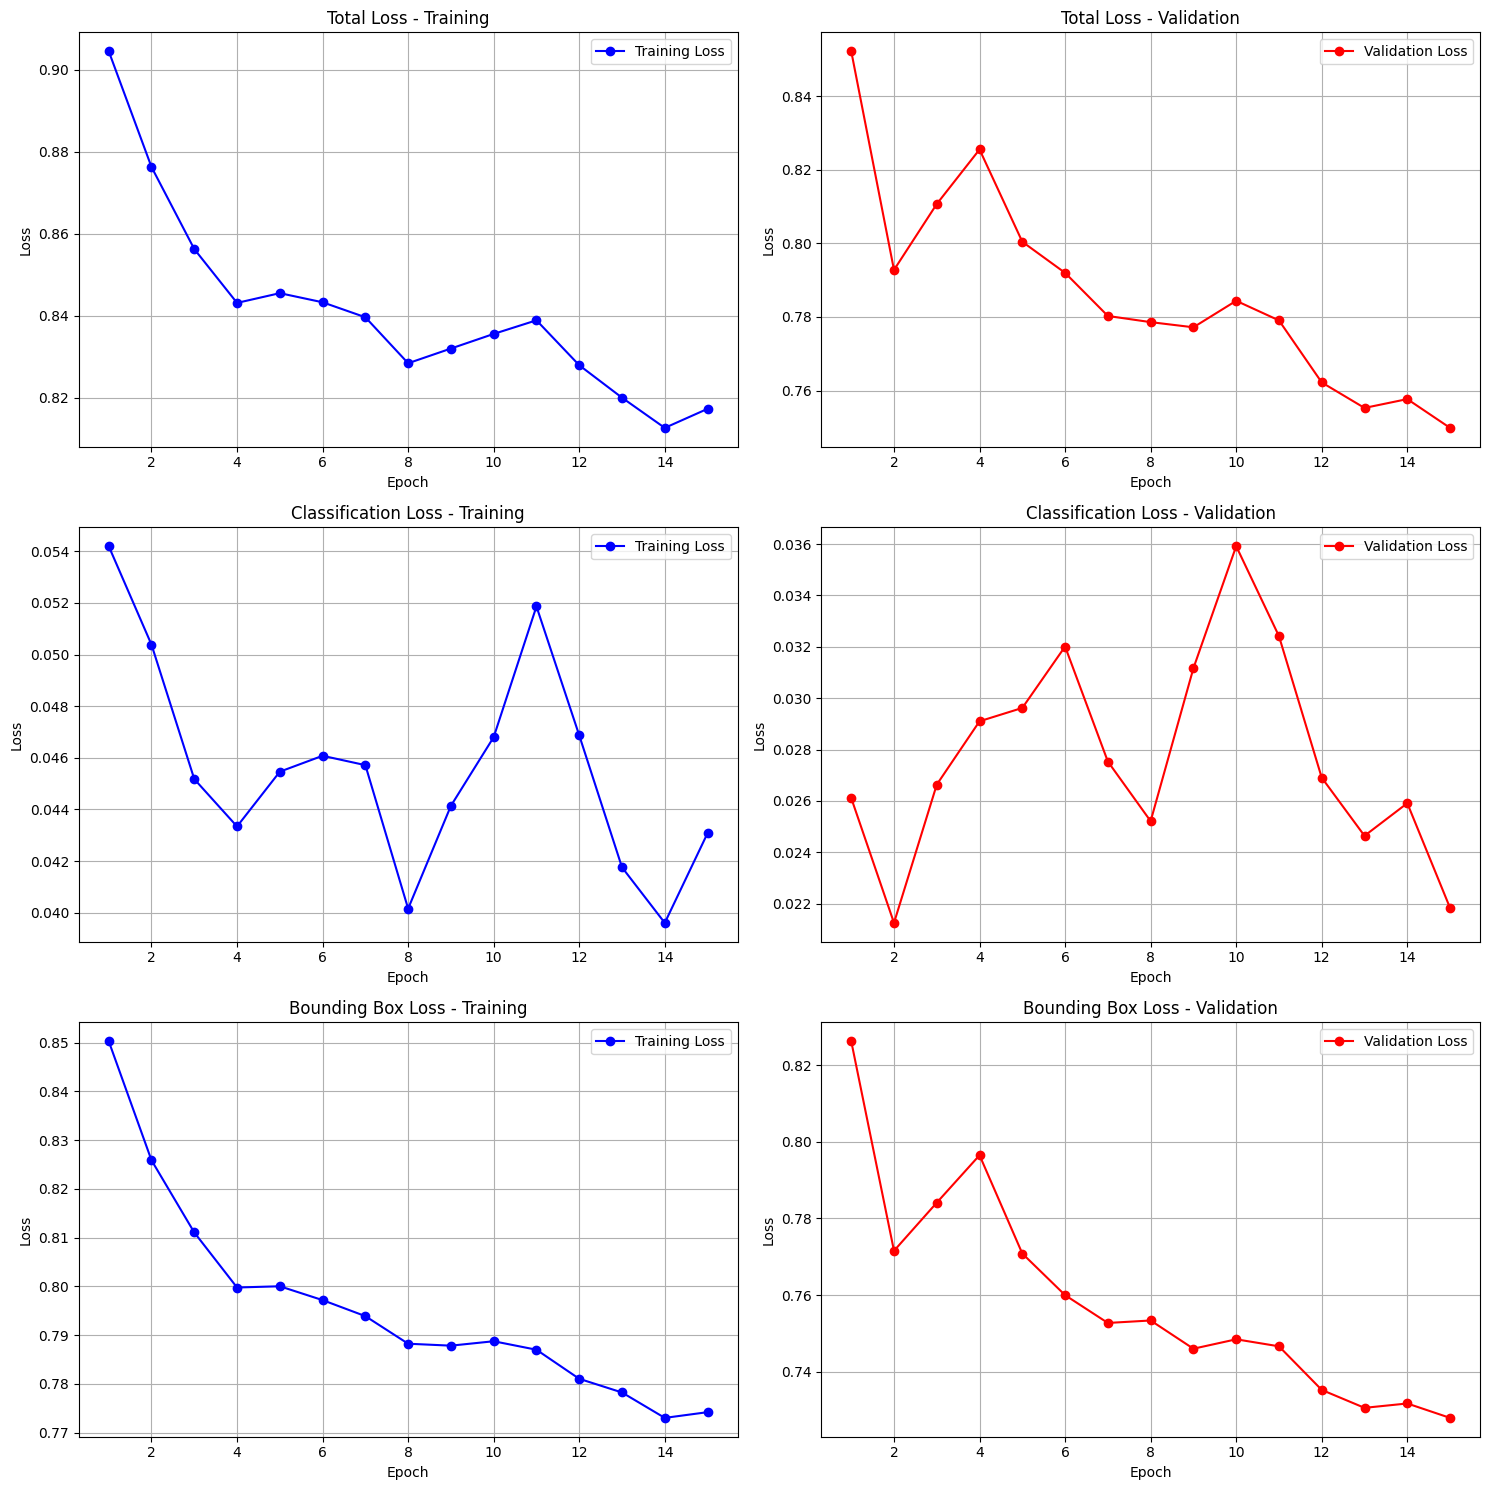

In [51]:
# PLotting function used
def plot_loss_curves(train_losses, val_losses, titles):

    epochs = range(1, len(train_losses[0]) + 1)

    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))  # 3 rows for each loss type, 2 columns for train and val

    for i, (train_loss, val_loss, title) in enumerate(zip(train_losses, val_losses, titles)):
        # Training losses
        axs[i, 0].plot(epochs, train_loss, 'bo-', label='Training Loss')
        axs[i, 0].set_title(title + ' - Training')
        axs[i, 0].set_xlabel('Epoch')
        axs[i, 0].set_ylabel('Loss')
        axs[i, 0].legend()
        axs[i, 0].grid(True)

        # Val losses
        axs[i, 1].plot(epochs, val_loss, 'ro-', label='Validation Loss')
        axs[i, 1].set_title(title + ' - Validation')
        axs[i, 1].set_xlabel('Epoch')
        axs[i, 1].set_ylabel('Loss')
        axs[i, 1].legend()
        axs[i, 1].grid(True)

    plt.tight_layout()
    plt.show()


train_losses = [train_epoch_losses, train_obj_losses, train_bbox_losses] #Train Data
val_losses = [val_epoch_losses, val_obj_losses, val_bbox_losses] #Val Data
titles = ['Total Loss', 'Classification Loss', 'Bounding Box Loss'] #Title :)

plot_loss_curves(train_losses, val_losses, titles)


Epoch 1
Epoch 1, Iteration 10, Avg Loss: 1.6237, Obj Loss: 0.6527, BBox Loss: 0.9710
Epoch 1, Iteration 20, Avg Loss: 3.2604, Obj Loss: 1.3402, BBox Loss: 1.9201
Epoch 1, Iteration 30, Avg Loss: 4.8529, Obj Loss: 1.9893, BBox Loss: 2.8636
Epoch 1, Iteration 40, Avg Loss: 6.5450, Obj Loss: 2.7201, BBox Loss: 3.8250
Epoch 1, Iteration 50, Avg Loss: 8.3782, Obj Loss: 3.5761, BBox Loss: 4.8021
Epoch 1, Iteration 60, Avg Loss: 10.2106, Obj Loss: 4.4336, BBox Loss: 5.7769
Epoch 1, Iteration 70, Avg Loss: 12.0287, Obj Loss: 5.2721, BBox Loss: 6.7566
Epoch 1, Iteration 80, Avg Loss: 13.7229, Obj Loss: 6.0085, BBox Loss: 7.7144
Epoch 1, Iteration 90, Avg Loss: 15.3772, Obj Loss: 6.7126, BBox Loss: 8.6646
Epoch 1, Iteration 100, Avg Loss: 17.2079, Obj Loss: 7.5651, BBox Loss: 9.6428
Epoch 1, Iteration 110, Avg Loss: 19.0866, Obj Loss: 8.4597, BBox Loss: 10.6269
Epoch 1, Iteration 120, Avg Loss: 20.9410, Obj Loss: 9.3362, BBox Loss: 11.6048
Epoch 1, Iteration 130, Avg Loss: 22.8123, Obj Loss: 10.

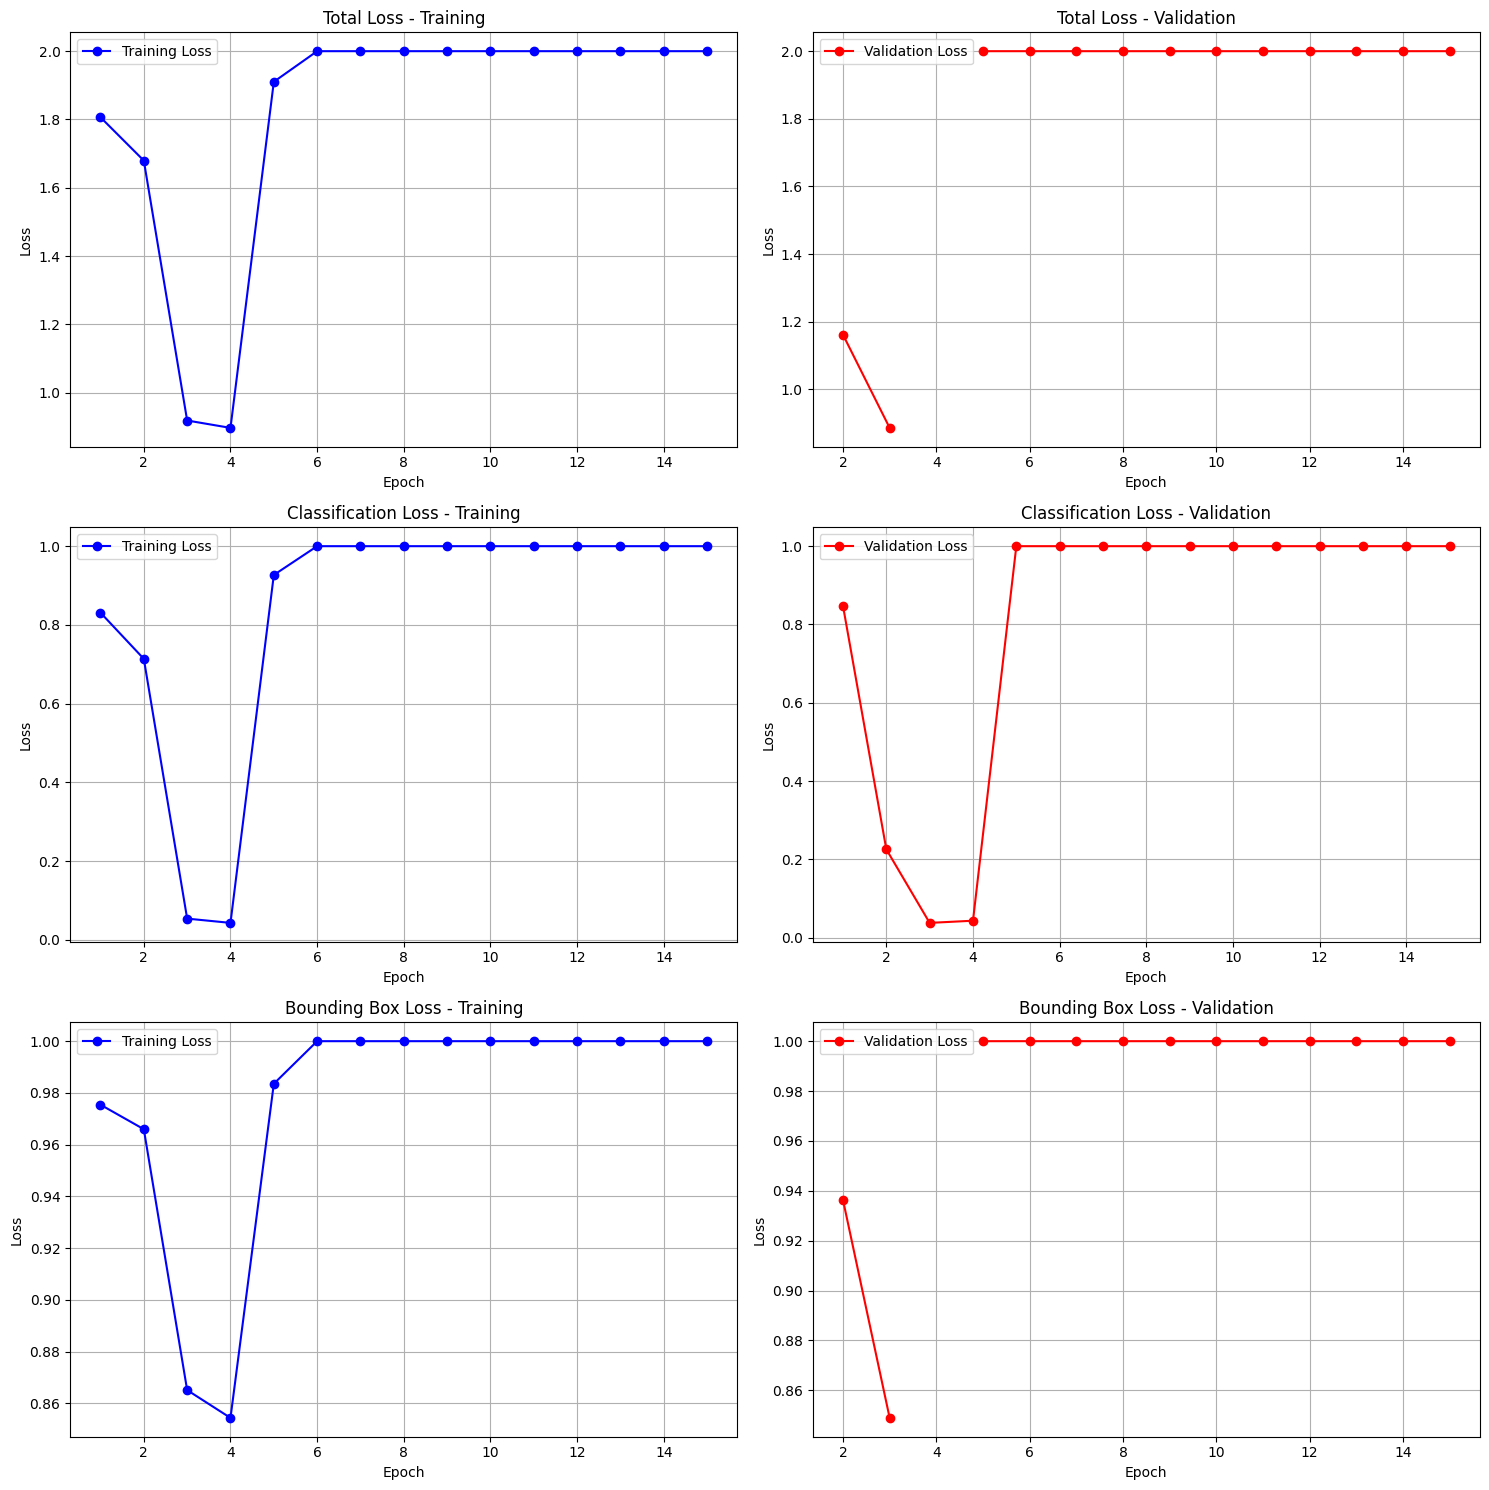

---